# Personal Information
Name: **Khwezi Rasmussen**

StudentID: **13134507**

Email: [**khwezi.rasmussen@student.uva.nl**](youremail@student.uva.nl)

Submitted on: **01.04.2025**

# Data Context
The data for this thesis has been sourced from the SAPP website (SAPP.co.zw), ETAVI Renewables, and the Zambezi River Authorities.

The primary dataset includes hourly historical **Day-Ahead Market (DAM)** price data from the SAPP Market site, covering key variables such as `delivery date`, `hour`, and `price (USD/MWh)` — the main target for forecasting. It also includes `Tati-normalized output` and `E_Grid (MW)`, representing power generation and grid supply levels, alongside `revenues (USD)` to capture market performance and supply-demand dynamics.

Complementary data from the Tati generation facility, including solar generation profiles and hydrological data from the Zambezi River Authorities, provide critical insights into electricity price fluctuations. The solar generation data includes key variables such as solar irradiance (`GlobHor`, `DiffHor`, `GlobInc`), `ambient temperature (T_Amb)`, and energy metrics (`EArray`, `E_Grid`, `PR`). These are essential for analyzing how solar power generation impacts electricity pricing. If hourly data is unavailable, monthly values will be repeated for each hour to maintain consistency, though this approach may limit the ability to analyze intra-day variations.

In addition, hydrological data on **Kariba Lake levels** and **Zambezi River flows** at Nanas Farm, Ngonye, and Chavuma (from 1990 to 2025) provide valuable context for understanding water availability and its effect on hydroelectric power production, further influencing electricity price dynamics. Together, these datasets offer a comprehensive view of the factors driving market fluctuations."

# Data Description

**Key Insights for Electricity Price Forecasting**
*Revenue Drivers*: Energy production (not price fluctuations) is the main driver of revenue, with a strong correlation between Tati-normalized output and E_Grid.

*Price and Output*: Price has a weak correlation with output, suggesting that volume sold is more impactful on revenue than price changes.

*Price Distribution*: Prices are right-skewed, with extreme spikes over 200 USD/MWh and increased volatility since 2020, indicating market shocks.

## Modeling Needs
LSTMs with attention mechanisms or hybrid models (e.g., LSTM-GARCH) are essential to handle extreme price movements and market shifts.

**Lag Recommendations for EPF Models:**
- ARIMA/SARIMA: Begin with lags of 7 to 14 days and refine using AIC/BIC for optimal selection.
- Machine Learning (LSTM): Use lags of 30–50 days to capture both short-term trends and seasonal cycles.

## Important Features
Most important features identified are Hour, Volatility (1 Day), Revenues, Level Kariba and E_Grid.

In [1]:
# Imports libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
# from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import re
from sklearn.preprocessing import MinMaxScaler

# Day-Ahead Market Data

### Data Loading

In [2]:
folder_path = '../../Data/DAM Prices and Captured Prices/DAM*.xlsx'
excel_files = glob.glob(folder_path)
excel_files

['../../Data/DAM Prices and Captured Prices/DAM__01-Jan-2024_To_31-Dec-2024_114.xlsx',
 '../../Data/DAM Prices and Captured Prices/DAM__01-Jan-2022_To_31-Dec-2022_4.xlsx',
 '../../Data/DAM Prices and Captured Prices/DAM__01-Jan-2020_To_31-Dec-2020_188.xlsx',
 '../../Data/DAM Prices and Captured Prices/DAM__01-Jan-2018_To_31-Dec-2018_102.xlsx',
 '../../Data/DAM Prices and Captured Prices/DAM__01-Jan-2015_To_31-Dec-2015_171.xlsx',
 '../../Data/DAM Prices and Captured Prices/DAM__01-Jan-2021_To_31-Dec-2021_76.xlsx',
 '../../Data/DAM Prices and Captured Prices/DAM__01-Jan-2019_To_31-Dec-2019_105.xlsx',
 '../../Data/DAM Prices and Captured Prices/DAM__01-Jan-2016_To_31-Dec-2016_66.xlsx',
 '../../Data/DAM Prices and Captured Prices/DAM__01-Jan-2023_To_31-Dec-2023_60.xlsx',
 '../../Data/DAM Prices and Captured Prices/DAM__01-Jan-2017_To_31-Dec-2017_165.xlsx']

In [3]:
# Path pattern for matching your Excel files
file_pattern = '../../Data/DAM Prices and Captured Prices/DAM*.xlsx'

# List all matching files using glob
excel_files = glob.glob(file_pattern)

# Create an empty list to store DataFrames
df_list = []

# Loop through all the Excel files and read them
for file in excel_files:
    # Read the Excel file into a DataFrame
    temp_df = pd.read_excel(file)
    
    # Append the DataFrame to the list
    df_list.append(temp_df)

# Concatenate all DataFrames into one
df_DAM = pd.concat(df_list, ignore_index=True)

In [4]:
# Rename column for simplicity
df_DAM.rename(columns={'DeliveryDay-(yyyy/MM/dd)': 'DeliveryDay'}, inplace=True)

# Ensure 'DeliveryDay' column is in datetime format
df_DAM['DeliveryDay'] = pd.to_datetime(df_DAM['DeliveryDay'], errors='coerce', format='%Y/%m/%d')

# Retain relevant years
df_DAM = df_DAM[(df_DAM['DeliveryDay'] >= '2017-01-01') & (df_DAM['DeliveryDay'] <= '2024-12-31')]

# Sort the DataFrame by 'DeliveryDay'
df_DAM.sort_values(by=['DeliveryDay', 'DeliveryHour'], ascending=True, inplace=True)

In [5]:
df_DAM.head()

Area DeliveryDay DeliveryHour  Price (USD/MWh)  \
76752  All Areas  2017-01-01        00-01            31.97   
76753  All Areas  2017-01-01        01-02            31.79   
76754  All Areas  2017-01-01        02-03            31.75   
76755  All Areas  2017-01-01        03-04            31.76   
76756  All Areas  2017-01-01        04-05            31.72   

       Tati- normalised output  E_Grid (Mw)  Revenues (USD)  
76752                      0.0          0.0             0.0  
76753                      0.0          0.0             0.0  
76754                      0.0          0.0             0.0  
76755                      0.0          0.0             0.0  
76756                      0.0          0.0             0.0

## Data Overview and Structure

### DAM dataset

#### Summary of `df.describe()`

The `df.describe()` summary provides key statistical insights into the dataset:

- **Price (USD/MWh):** The price ranges from **0 to 400**, with a **mean of 82.20** and a **standard deviation of 65.88**, indicating significant price fluctuations.  
- **Tati-normalised output & E_Grid (MW):** Both have a **median of 0**, suggesting many periods of no generation. However, their **75th percentiles (0.6377 and 66.96, respectively)** indicate substantial production when active.  
- **Revenues (USD):** Highly skewed, with a **median of 0**, but a **maximum of 34,360**, reflecting variability in revenue generation.  
- **DeliveryDay (Date Range):** Spans from **April 2015 to December 2024**, covering nearly a decade of electricity market data.  
- **Variability & Anomalies:** The presence of negative or near-zero values in **output and revenue** suggests possible system inefficiencies, data gaps, or operational downtimes.  

These descriptive statistics highlight the volatility in electricity prices and revenues, reinforcing the need for robust forecasting models.


In [6]:
df_DAM.describe() # General descriptions of the numerical values

DeliveryDay  Price (USD/MWh)  Tati- normalised output  \
count                70128     70128.000000             70128.000000   
mean   2020-12-31 12:00:00        82.069807                 0.269904   
min    2017-01-01 00:00:00         0.000000                -0.000048   
25%    2019-01-01 00:00:00        33.430000                 0.000000   
50%    2020-12-31 12:00:00        60.020000                 0.000000   
75%    2023-01-01 00:00:00        98.980000                 0.637510   
max    2024-12-31 00:00:00       400.000000                 0.875543   
std                    NaN        70.411754                 0.340959   

        E_Grid (Mw)  Revenues (USD)  
count  70128.000000    70128.000000  
mean      28.339942     2340.587300  
min       -0.005000       -1.861950  
25%        0.000000        0.000000  
50%        0.000000        0.000000  
75%       66.938500     3854.359725  
max       91.932000    34360.330080  
std       35.800648     3827.407392

Checking missing values. There's 24 of them. Since it's a relatively small number compared to the size of the dataset we can drop them.

In [7]:
# Check for missing values
print(df_DAM.isnull().sum()) # 24 NaN values. Drop them
df_DAM = df_DAM.dropna()
df_DAM.drop(columns='Area',inplace=True) # Area is All Areas

Area                       0
DeliveryDay                0
DeliveryHour               0
Price (USD/MWh)            0
Tati- normalised output    0
E_Grid (Mw)                0
Revenues (USD)             0
dtype: int64


Converting the delivery hour to a single value.

In [8]:
df_DAM['DeliveryHour'] = df_DAM['DeliveryHour'].str.split('-').str[0].astype(int) # Convert to Single Hour Int

#### Correlation Matrix
The correlation matrix provides insights into the relationships between key variables in the electricity market. The strongest correlation exists between **Tati-normalized output and E_Grid (1.00)**, suggesting that grid energy output is directly proportional to normalized plant output. Similarly, **revenues (USD) show a high correlation with both E_Grid (0.80) and Tati-normalized output (0.80)**, indicating that revenue generation is largely driven by energy production rather than price fluctuations. Interestingly, price (USD/MWh) has a weak correlation with energy output (0.03) but a slightly stronger correlation with revenues (0.32), implying that while price impacts revenue, volume of electricity sold plays a more dominant role. The lack of significant correlation between delivery time variables (DeliveryDay, DeliveryHour) and price suggests that short-term time factors do not heavily influence price variations in this dataset. 

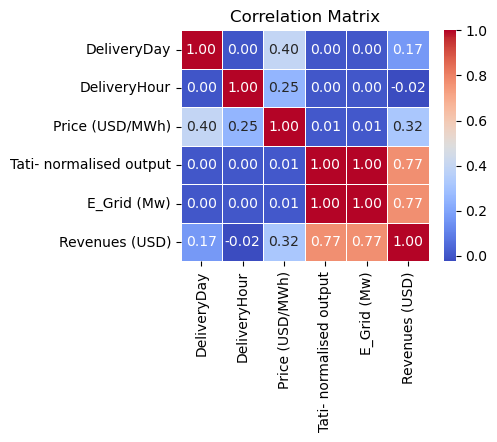

In [9]:
# Correlation matrix
plt.figure(figsize=(4, 3))
sns.heatmap(df_DAM.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show() # Strong correlations between Tati,  E_grid and Revenue


#### Distribution of Hourly Electricity Prices
The histogram shows the distribution of hourly electricity prices (USD/MWh), revealing a **right-skewed distribution** with a peak around **30-50 USD/MWh**. The density plot suggests multiple modes, indicating potential price regimes or structural shifts in the market. Higher price spikes beyond **200 USD/MWh** suggest occasional extreme price fluctuations, which could be driven by demand surges, supply shortages, or market interventions. Understanding this distribution is crucial for **Electricity Price Forecasting (EPF)**, as it highlights the importance of modeling not just the central tendency but also the probability of extreme price movements.



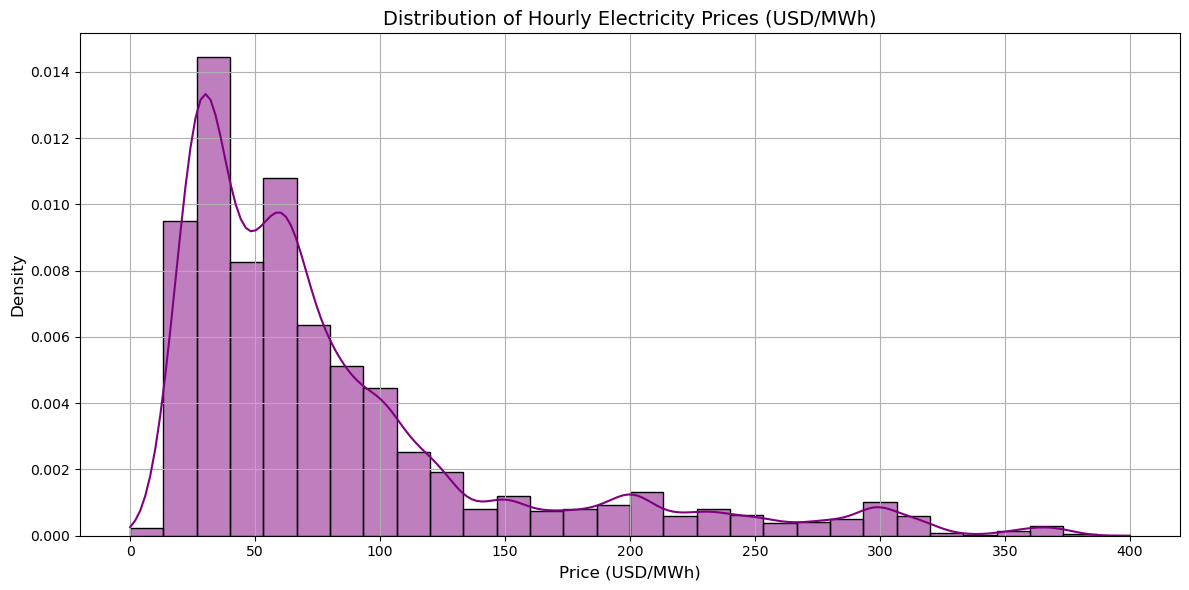

In [10]:
# Plotting the distribution using Histogram and KDE
plt.figure(figsize=(12, 6))

# Plot histogram with KDE (Kernel Density Estimate) on the same plot
sns.histplot(df_DAM['Price (USD/MWh)'], kde=True, bins=30, color='purple', stat='density')

# Adding title and labels
plt.title('Distribution of Hourly Electricity Prices (USD/MWh)', fontsize=14)
plt.xlabel('Price (USD/MWh)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(True)
plt.tight_layout()

plt.show()


##### Boxplot of Hourly Electricity Prices  
The boxplot of hourly electricity prices (USD/MWh) reveals a **highly skewed distribution** with numerous **outliers** on the upper end. The interquartile range (IQR) spans from around **30 to 100 USD/MWh**, suggesting that most prices fall within this range. However, the presence of extreme values beyond **200 USD/MWh** highlights periods of **price spikes**, likely caused by demand surges, supply constraints, or market interventions. These outliers emphasize the need for robust forecasting models that can handle extreme price fluctuations.

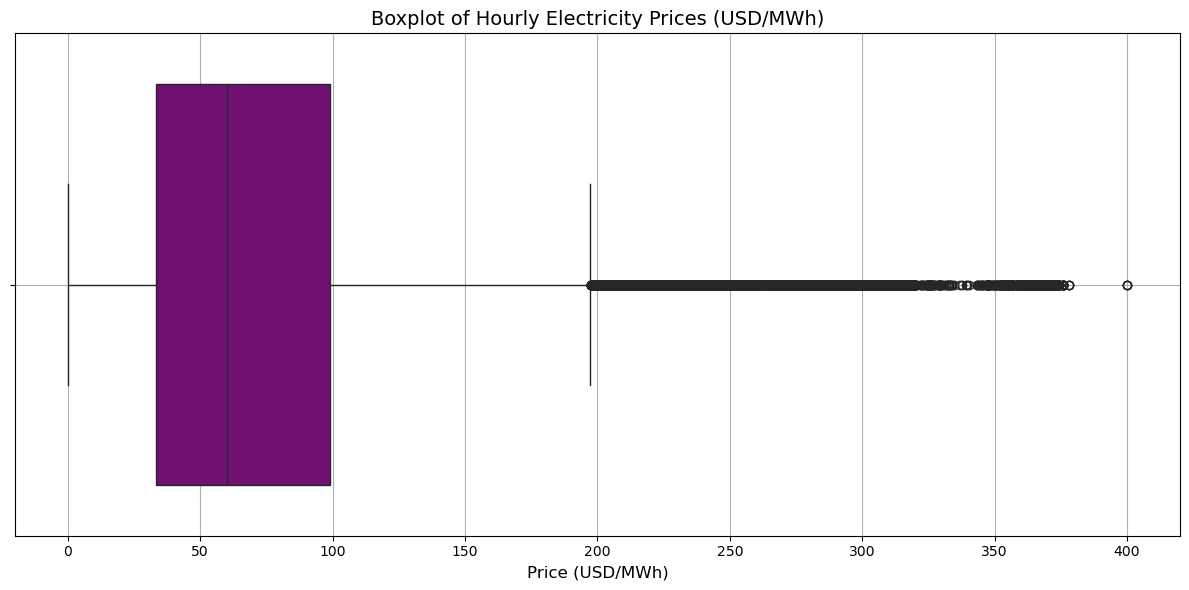

In [11]:
# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_DAM['Price (USD/MWh)'], color='purple')

# Adding title and labels
plt.title('Boxplot of Hourly Electricity Prices (USD/MWh)', fontsize=14)
plt.xlabel('Price (USD/MWh)', fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

#### Time Series plot of DAM prices per year
The time series plot illustrates electricity prices from 2015 to 2024, segmented by year and overlaid with a monthly average trendline. Initially, prices exhibit moderate fluctuations, but from 2020 onward, there is a sharp increase in volatility and price levels, likely driven by external factors such as supply chain disruptions, policy changes, or market shocks. The monthly average trendline (orange) highlights recurring seasonal patterns, with peaks and troughs suggesting demand-driven cycles. The price surge in recent years, particularly in 2023 and 2024, indicates a shift in market dynamics, reinforcing the need for predictive modeling to anticipate future price behavior in the Southern African Power Pool.

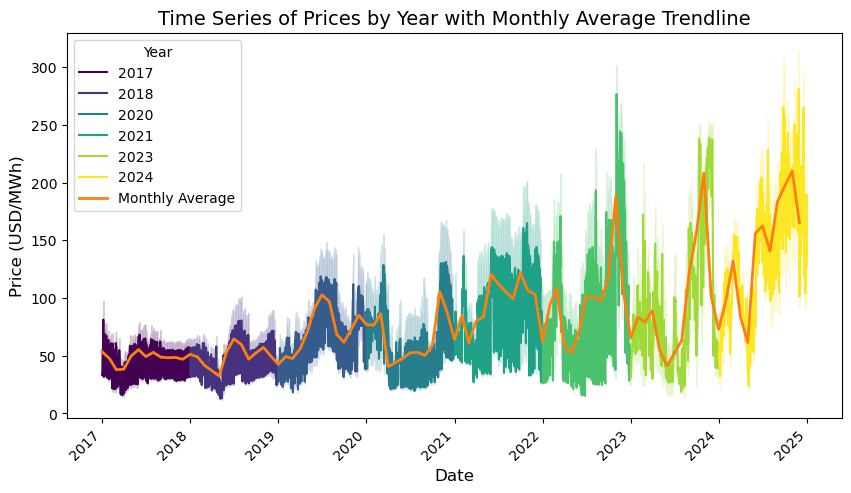

In [12]:
# Extract the year from 'DeliveryDay' for color grouping
df_DAM['Year'] = df_DAM['DeliveryDay'].dt.year
df_DAM['Month'] = df_DAM['DeliveryDay'].dt.to_period('M')
df_DAM['Day'] = df_DAM['DeliveryDay'].dt.to_period('D')


# Calculate the monthly average price
monthly_avg_dam = df_DAM.groupby('Month')['Price (USD/MWh)'].mean().reset_index()
monthly_avg_dam['Month'] = monthly_avg_dam['Month'].dt.to_timestamp()

# Create the plot
plt.figure(figsize=(10, 5))

# Plot the time series with each year in a different color
sns.lineplot(x='DeliveryDay', y='Price (USD/MWh)', hue='Year', data=df_DAM, palette='viridis')

# Plot the trendline for the monthly average
sns.lineplot(
    x='Month', 
    y='Price (USD/MWh)', 
    data=monthly_avg_dam, 
    color='#FF7F0E', 
    linewidth=2, 
    label='Monthly Average'
)

# Customize the plot
plt.title('Time Series of Prices by Year with Monthly Average Trendline', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD/MWh)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Year')

# Show the plot
plt.show()

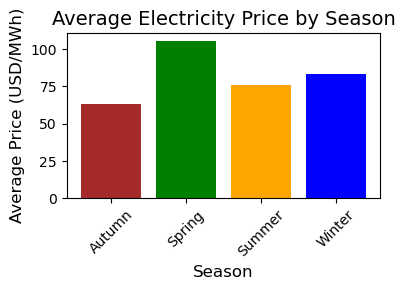

In [13]:
# Add a column for season based on the 'Month' column
season_map = {
    1: 'Summer', 2: 'Summer', 3: 'Autumn', 4: 'Autumn', 5: 'Autumn', 
    6: 'Winter', 7: 'Winter', 8: 'Winter', 9: 'Spring', 10: 'Spring', 
    11: 'Spring', 12: 'Summer'
}
monthly_avg_dam['Season'] = monthly_avg_dam['Month'].dt.month.map(season_map)

# Now calculate the average price per season
seasonal_avg_price = monthly_avg_dam.groupby('Season')['Price (USD/MWh)'].mean().reset_index()

# Define custom colors for each season
colors = {'Summer': 'orange', 'Autumn': 'brown', 'Winter': 'blue', 'Spring': 'green'}

# Plotting
plt.figure(figsize=(4, 3))
plt.bar(seasonal_avg_price['Season'], seasonal_avg_price['Price (USD/MWh)'], 
        color=[colors[season] for season in seasonal_avg_price['Season']])

# Add title and labels
plt.title('Average Electricity Price by Season', fontsize=14)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Average Price (USD/MWh)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Here a Seasonal Decomposition will be performed by Seasonal Decomposition, Fourier Transform and Autocorellation

#### Seasonal Decomposition  

##### Seasonal Components  
The seasonal decomposition plots break down electricity prices into four key components:  

- **Observed (Blue):** Represents the actual recorded electricity prices over time.  
- **Trend (Yellow):** Captures the underlying long-term movement in electricity prices.  
- **Seasonal (Red):** Highlights recurring and predictable fluctuations within each year, such as seasonal demand shifts.  
- **Residual (Green):** Represents unexplained, random variations not captured by the trend or seasonal components.  

---

##### Analysis & Conclusion  
From **2017 to 2019**, electricity prices exhibit **relatively stable fluctuations** with consistent seasonal patterns. However, starting in **2020**, a **significant increase in price levels and volatility** is observed, likely influenced by **global energy market disruptions, supply chain issues, or policy changes**. This trend continues into **2021 and 2022**, with prices reaching **higher peaks** and showing more irregular variations.  

The **seasonal component (red)** remains strong throughout the years, reflecting **recurring patterns** likely tied to:  
- Winter heating and summer cooling demand  
- Regulatory pricing adjustments  
- Fuel price fluctuations  

However, from **2020 onward**, the **residual component (green) becomes more volatile**, suggesting increased **external shocks and market instability**.  

By **2023 and 2024**, electricity prices remain **elevated with continued fluctuations**, signaling a **new normal** in energy markets, characterized by:  
- Higher prices  
- Increased uncertainty  
- Greater volatility in residual components  

Possible causes include **geopolitical factors, policy changes, renewable energy integration, and shifts in supply and demand dynamics**.  

---

##### Final Takeaway  
The exploratory data analysis (EDA) of the DAM reveals a structural shift in electricity price behavior after 2020, characterized by increasing price levels and volatility. While seasonal cycles remain predictable, the trend indicates a long-term upward movement, and the residual component highlights increasing uncertainty in the market.

For electricity price forecasting (EPF) in the Southern African Power Pool (SAPP), these findings underscore the importance of incorporating:

- Seasonal patterns to account for recurring fluctuations in demand and supply.
- Trend dynamics to capture long-term shifts in market behavior.
- Residual variability to assess market shocks and uncertainty.

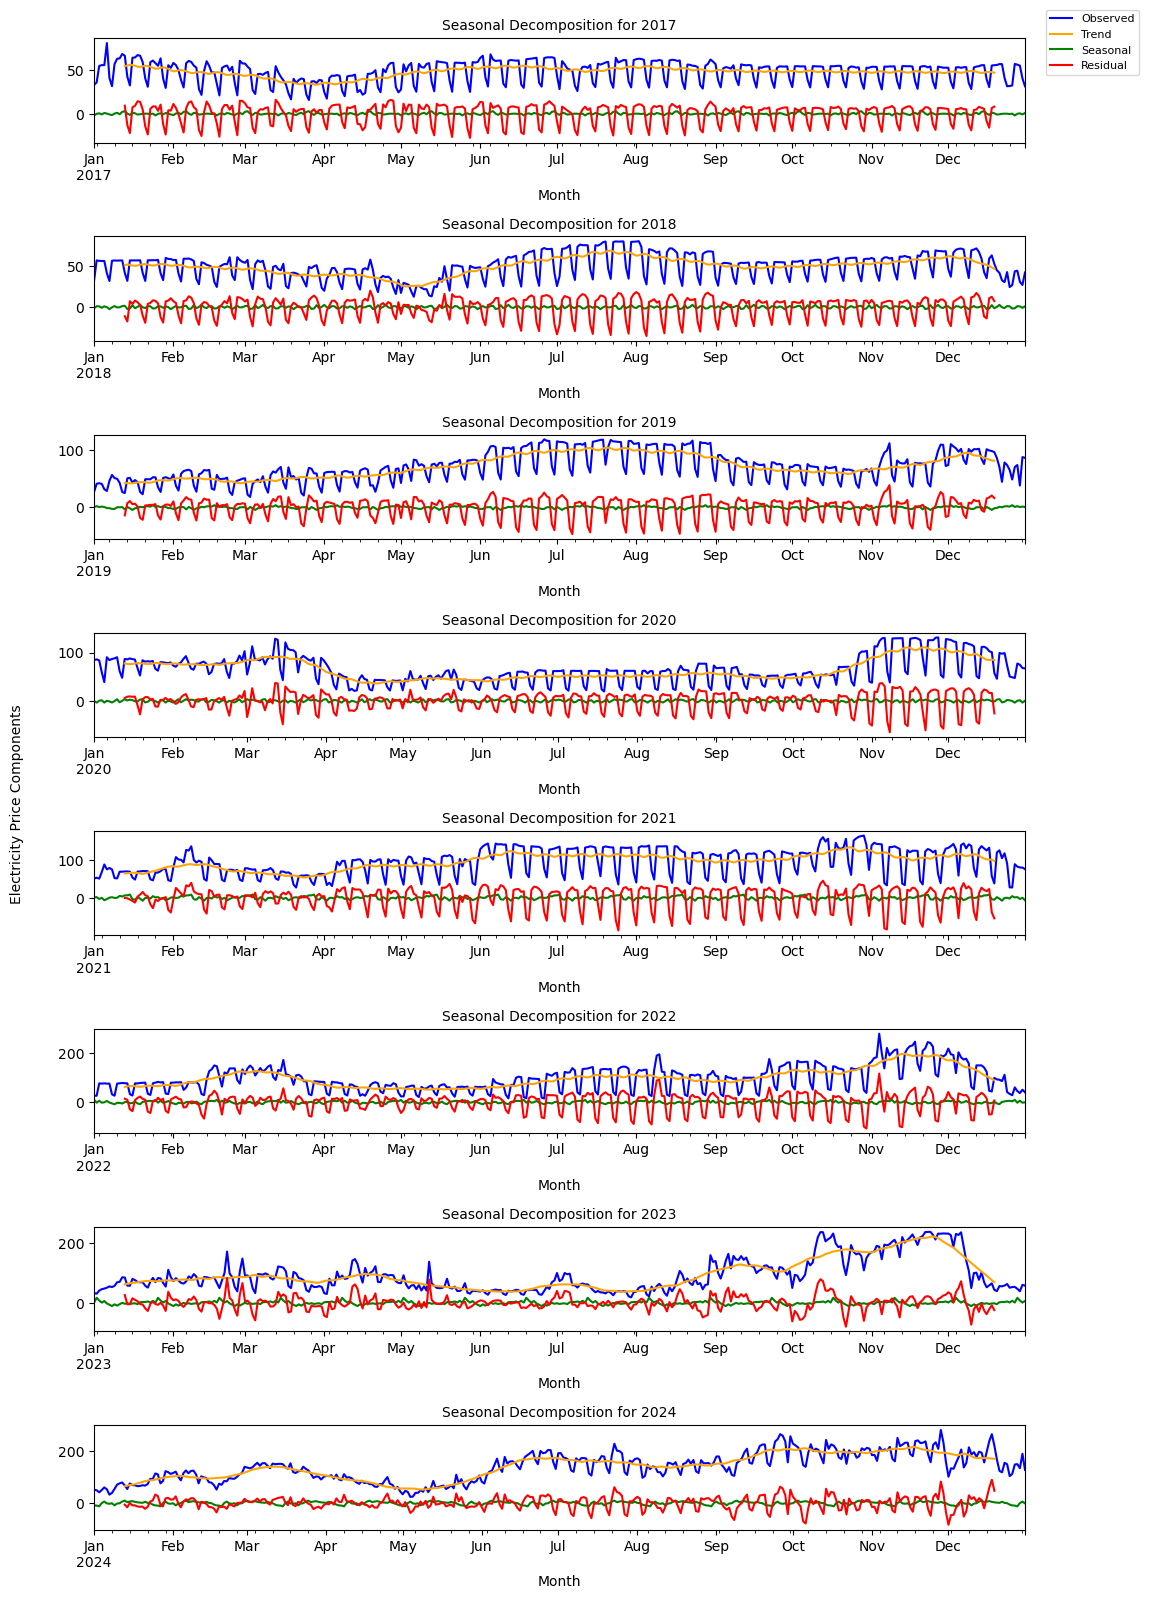

In [14]:
# Ensure 'DeliveryDay' is a datetime index
df_DAM.set_index('DeliveryDay', inplace=True, drop=False)
# Create subplots for each year
fig, axs = plt.subplots(len(range(2017, 2025)), 1, figsize=(10, 16))

# Loop through the years and plot each decomposition
for i, year in enumerate(range(2017, 2025)):    # Filter data for each year
    df_year = df_DAM[df_DAM.index.year == year]
    
    # Resample the data for each year
    df_year_resampled = df_year.resample('D').mean()  # Resample to daily for each year

    # Perform seasonal decomposition on the 'Price (USD/MWh)' column
    decomposition = sm.tsa.seasonal_decompose(df_year_resampled['Price (USD/MWh)'], model='additive', period=24)

    # Plot the decomposition result for the year without the legend
    decomposition.observed.plot(ax=axs[i], color='blue')
    decomposition.trend.plot(ax=axs[i], color='orange')
    decomposition.seasonal.plot(ax=axs[i], color='green')
    decomposition.resid.plot(ax=axs[i], color='red')

    # Set the title for the subplot
    axs[i].set_title(f'Seasonal Decomposition for {year}', fontsize=10)
    axs[i].set_xlabel("Month")
    # axs[i].set_ylabel("Electricity Price Components")  

# Add a single legend outside the plot and make it smaller
fig.legend(['Observed', 'Trend', 'Seasonal', 'Residual'], loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
fig.text(-0.03, 0.5, "Electricity Price Components", va='center', rotation='vertical')
# Adjust layout and show the plot
plt.tight_layout()
plt.show()


#### **Fourier Spectrum Analysis of Electricity Prices**  
The Fourier spectrum reveals key periodic patterns in electricity prices. If the Fourier Transform shows dominant frequencies corresponding to weekly or monthly cycles, this confirms that seasonal and regulatory effects significantly impact DAM prices. 

The **large spike at 0 frequency** represents the overall mean price level, capturing the long-term trend without fluctuations. Several **smaller peaks at specific frequencies (-0.43, -0.3, 0.18, 0.28, 0.43 cycles per day)** indicate dominant cyclical patterns in price movements. These frequencies correspond to time cycles of approximately **2.3, 3.3, 3.6, and 5.6 days**, suggesting recurring fluctuations likely influenced by daily and weekly demand shifts, market behaviors, and regulatory adjustments. The presence of both positive and negative frequencies is expected due to the symmetry of the Fourier Transform. The lower amplitude outside these peaks indicates that most of the price variation is explained by these structured cycles rather than random noise. 

This insight can guide further analysis using autocorrelation (ACF/PACF) to validate these cycles in the time domain and inform forecasting models such as SARIMA or Fourier-based regression. 

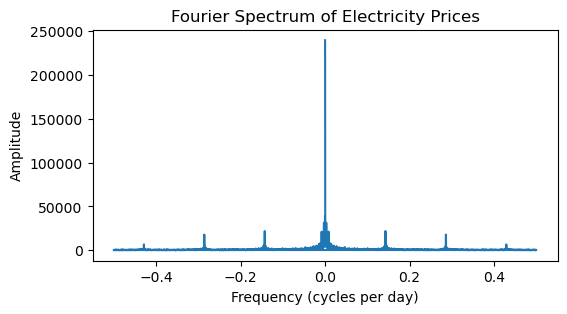

In [15]:
daily_avg_dam = df_DAM.groupby('Day')['Price (USD/MWh)'].mean().reset_index()

# Ensure 'Price (USD/MWh)' is numeric and remove any NaN values
data = daily_avg_dam['Price (USD/MWh)'].dropna().values  

# Perform the Fourier Transform
fft_result = np.fft.fft(data)
frequencies = np.fft.fftfreq(len(data))

# Plot the Fourier spectrum
plt.figure(figsize=(6, 3))
plt.plot(frequencies, np.abs(fft_result))
plt.title('Fourier Spectrum of Electricity Prices')
plt.xlabel('Frequency (cycles per day)')
plt.ylabel('Amplitude')
plt.show()

#### **Autocorrelation Analysis of Electricity Prices**  

The autocorrelation function (ACF) helps determine how past electricity prices influence future prices by measuring lag dependence. This is crucial for time series forecasting models such as ARIMA, SARIMA, and LSTM, as it identifies short-term dependencies and recurring patterns in the data.  

##### **Key Insights from ACF**  
- **Short-term dependencies:** The ACF shows strong correlations at small lags, indicating that recent prices significantly influence near-future prices.  
- **Recurring cycles:** Periodic fluctuations in the ACF confirm patterns in electricity prices, which align with the Fourier Transform results, highlighting dominant cycles of approximately 2, 3, 4, and 6 days.  
- **Long-term correlations:** A gradual decline in autocorrelation over longer lags suggests that past prices lose influence over time, while a partial recovery beyond 200 days indicates seasonal effects.  

In addition to ACF, the partial autocorrelation function (PACF) can help identify the appropriate number of lag terms for autoregressive models. If PACF shows a sharp cutoff after a few lags, AR or ARIMA models may be suitable. Conversely, if ACF exhibits strong correlations at daily or weekly lags (e.g., 24-hour or 7-day cycles), SARIMA or deep learning models can help capture these dependencies.  

##### **Conclusion**  
The ACF confirms both short-term cyclical trends (e.g., weekly demand fluctuations) and long-term seasonal patterns (e.g., yearly cycles). 

**Lag Recommendations**
For ARIMA/SARIMA: Start with lags up to 7 or 14 days and refine using AIC/BIC.
For Machine Learning (LSTM): Consider lags up to 30–50 days for capturing both short-term trends and seasonal cycles.

The choice of lag terms differs between ARIMA/SARIMA and LSTM/XGBoost due to how these models handle temporal dependencies. ARIMA and SARIMA assume a linear relationship between past and future values, meaning they rely on a small number of significant lags (typically 7–14 days) as indicated by the Partial Autocorrelation Function (PACF). Using too many lags in these models can lead to overfitting without improving accuracy. 

In contrast, LSTM and XGBoost can capture nonlinear dependencies and benefit from longer lag windows (30–50 days), allowing them to learn both short-term fluctuations and long-term trends effectively. The key difference lies in ARIMA’s reliance on direct lagged correlations versus LSTM/XGBoost’s ability to model complex patterns over extended timeframes.

<Figure size 1000x500 with 0 Axes>

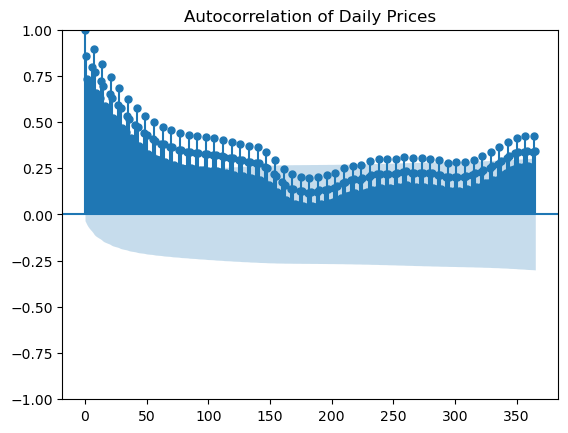

In [16]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10, 5))
plot_acf(data, lags=365)  # Up to 1 year of lags
plt.title('Autocorrelation of Daily Prices')
plt.show()

#### **Partial Autocorrelation Analysis of Electricity Prices**  

The **Partial Autocorrelation Function (PACF)** plot provides insight into the direct relationships between electricity prices at different time lags while controlling for intermediate effects. The significant spikes at short lags (e.g., 1, 2, and 3 days) indicate strong short-term dependencies, suggesting that recent prices have a substantial impact on near-future prices. Additionally, periodic spikes at around 7, 10, and 14 days highlight the presence of weekly and biweekly cycles, likely driven by recurring supply-demand fluctuations. A notable drop around lag 8 days may indicate shifts in market behavior or external influences affecting price trends intermittently. Beyond 20 lags, the diminishing impact of past prices suggests that long-term dependencies weaken over time. These findings suggest that **AutoRegressive (AR) models** may be effective for short-term forecasting, while **Seasonal ARIMA (SARIMA)** could better capture both short-term and seasonal effects. The results also align with the **Fourier Transform and Autocorrelation Function (ACF) analysis**, reinforcing the existence of periodic fluctuations in the electricity market. Understanding these patterns will be essential in developing accurate forecasting models for electricity prices in the **Southern African Power Pool (SAPP) Day-Ahead Market (DAM)**.


<Figure size 800x500 with 0 Axes>

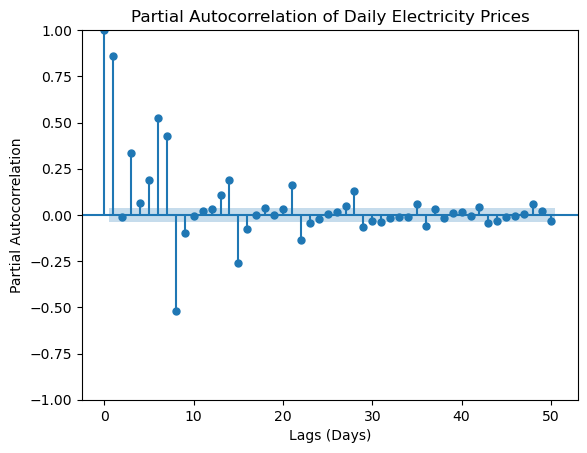

In [17]:
from statsmodels.graphics.tsaplots import plot_pacf

# Plot PACF
plt.figure(figsize=(8, 5))
plot_pacf(data, lags=50, method='ywm')  # You can adjust lags as needed
plt.title('Partial Autocorrelation of Daily Electricity Prices')
plt.xlabel('Lags (Days)')
plt.ylabel('Partial Autocorrelation')
plt.show()


#### Volatiility
The techniques applied—**seasonal decomposition**, **Fourier transform**, and **autocorrelation**—focus on understanding patterns and relationships in the time series. Volatility analysis provides a **complementary perspective**, emphasizing price **variability**, which is crucial when analyzing market prices or financial time series.

Volatility is a crucial factor in electricity price forecasting (EPF), as it quantifies uncertainty and market fluctuations over time. The analysis reveals increasing price variability, with short-term (1-day, 3-day) volatility exhibiting frequent spikes and long-term (30-day) volatility highlighting structural market shifts. This trend suggests growing instability in electricity prices, requiring forecasting models that can adapt to both rapid price swings and broader market changes.

High short-term volatility implies the need for adaptive models to capture rapid price swings, while long-term trends highlight the importance of incorporating seasonal patterns and market regime changes. These insights emphasize the value of hybrid models (e.g., SARIMA, LSTMs) that balance short-term responsiveness with long-term trend capture, enhancing forecasting accuracy. Approaches like SARIMA or hybrid deep learning models can effectively integrate seasonal patterns and structural shifts to improve electricity price forecasting.

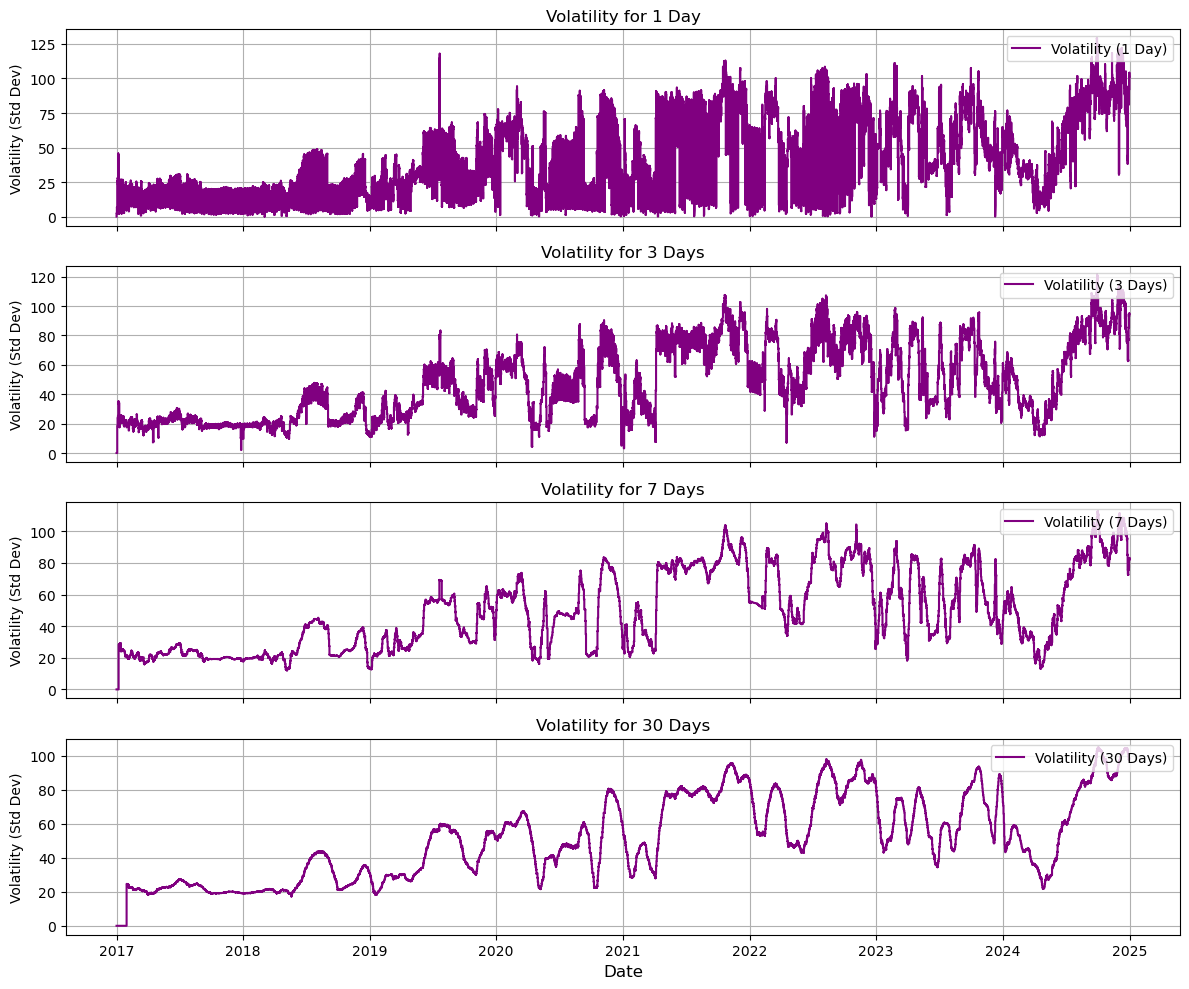

In [18]:
# Define window sizes based on 1, 3, 7, and 30 days (in hours)
windows = {
    '1 Day': 1 * 24,   # 1 day = 24 hours
    '3 Days': 3 * 24,  # 3 days = 72 hours
    '7 Days': 7 * 24,  # 7 days = 168 hours
    '30 Days': 30 * 24 # 30 days = 720 hours
}

# Create subplots for each window size
fig, axs = plt.subplots(len(windows), 1, figsize=(12, 10), sharex=True)

for i, (label, window_size) in enumerate(windows.items()):
    # Calculate the rolling standard deviation (volatility) for each window size
    df_DAM[f'Volatility_{label}'] = df_DAM['Price (USD/MWh)'].rolling(window=window_size).std()
    df_DAM[f'Volatility_{label}'] = df_DAM[f'Volatility_{label}'].fillna(0)

    # Plot the volatility for the current window size
    axs[i].plot(df_DAM.index, df_DAM[f'Volatility_{label}'], label=f'Volatility ({label})', color='purple')
    axs[i].set_title(f'Volatility for {label}', fontsize=12)
    axs[i].set_ylabel('Volatility (Std Dev)', fontsize=10)
    axs[i].legend(loc='upper right')
    axs[i].grid(True)

# Set common labels and title
plt.xlabel('Date', fontsize=12)
plt.tight_layout()
plt.show()

# Zambezi River Authorities Data

## Loading the data
In this section, we focus on reading and processing the data from multiple points along the Zambezi River. The challenge comes from the fact that the files were created in Excel and are inconsistent in terms of formatting and how they represent the data. As a result, we need to process each file individually to ensure that the data is cleaned and formatted properly for further analysis.

### Data Processing
The following steps were performed:

1. **Date Parsing and Transformation**: The dataset contained month abbreviations (e.g., 'Jan', 'Feb') and year information in separate columns. A new numeric `Date` column in the `YYYYMMDD` format was created by combining the 'Actual Year', 'Month', and 'Day' columns. Month abbreviations were mapped to their corresponding numeric values to construct the full date.

2. **Handling Invalid Dates**: The `pd.to_datetime()` function with `errors='coerce'` was used to handle invalid or missing dates. Malformed or incomplete date values were converted to `NaT` (Not a Time), allowing for the removal of rows with invalid dates using `dropna()`.

3. **Filtering Data from a Specific Date**: After converting the `Date` column to the correct format, the dataset was filtered to include only rows starting from `2017-01-01`. This was achieved by comparing the `Date` column with the specified date in `YYYYMMDD` format.

These steps ensured the data was cleaned, structured, and ready for further analysis.


#### Defining the file pattern and helper function to ensure correct year format

In [19]:
# Dataset locations
file_pattern_ZRA = '../../Data/ZRA'

In [20]:
def check_year_format(year_str):
    """
    This function checks the format of the year and converts 'YYYY/YY' format
    to 'YYYY/YYYY' format. It skips NaN or non-string values.
    
    Args:
        year_str (str): The year in 'YYYY/YY' or 'YYYY/YYYY' format.
        
    Returns:
        str: The year in 'YYYY/YYYY' format or None if invalid.
    """
    # Skip NaN or non-string values
    if not isinstance(year_str, str):
        return year_str  # Returns the original value (could be NaN or other)

    # Check if the year format is 'YYYY/YY' (e.g., '2016/17')
    if re.match(r'\d{4}/\d{2}', year_str):
        # Convert 'YYYY/YY' to 'YYYY/YYYY' format
        year = year_str.split('/')
        full_year = f'{year[0]}/{int(year[0])+1}'
        return full_year
    
    # If the year is already in 'YYYY/YYYY' format, return it as is
    elif re.match(r'\d{4}/\d{4}', year_str):
        return year_str
    
    # Return the original value if the format is unrecognized
    return year_str


#### Individually processing each station file, as they have been saved variously

In [21]:
def clean_chavuma():
    chavuma = pd.read_csv(f'{file_pattern_ZRA}/chavuma.csv',delimiter=';')
    chavuma = chavuma.dropna(axis=1, how='all') # Drop NaN columns
    
    # Indexing from 2016/2017
    start_index = chavuma[chavuma['Unnamed: 1'] == 'Year: 2016/2017'].index[0]

    chavuma_2017 = chavuma.loc[start_index:].copy()
    # Extract the year value from rows containing 'Year:' and fill down
    chavuma_2017['Year'] = chavuma_2017['Unnamed: 1'].str.extract(r'Year:\s*(.*)')
    chavuma_2017['Year'] = chavuma_2017['Year'].apply(check_year_format)

    # Forward fill to propagate the year value until the next 'Year:'
    chavuma_2017['Year'] = chavuma_2017['Year'].ffill()

    chavuma_2017 = chavuma_2017.drop(columns=['Unnamed: 1'])
    columns = ['Day', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Year']

    # Rename the columns
    chavuma_2017.columns = columns
    return chavuma_2017

In [22]:
def clean_kariba():
    kariba = pd.read_csv(f'{file_pattern_ZRA}/kariba.csv', sep=';')

    kariba = kariba.dropna(axis=1, how='all') # Drop NaN columns

    # Indexing from 2016/2017
    start_index = kariba[kariba['Unnamed: 1'] == 'Daily Lake Levels in metres    for 2016/2017  Season'].index[0]
    
    kariba_2017 = kariba.loc[start_index:].copy()
    
    # Extract the year value from rows containing 'Year:' and fill down
    kariba_2017['Year'] = kariba_2017['Unnamed: 1'].str.extract(r'Daily Lake Levels in metres\s+for\s+(\d{4}/\d{4})')
    kariba_2017['Year'] = kariba_2017['Year'].apply(check_year_format)

    # Forward fill to propagate the year value until the next 'Year:'
    kariba_2017['Year'] = kariba_2017['Year'].ffill()
    columns = ['Day', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Year']

    # Rename the columns
    kariba_2017.columns = columns
    return kariba_2017

In [23]:
def clean_nana():
    nana = pd.read_csv(f'{file_pattern_ZRA}/nana.csv', sep=';')
    nana = nana.dropna(axis=1, how='all') # Drop NaN columns

    # Indexing from 2016/2017
    start_index = nana[nana['Unnamed: 1'] == "NANA'S FARM FLOWS 2016/2017 SEASON"].index[0]
    nana_2017 = nana.loc[start_index:].copy()

    # Adjust the regex to capture both "NANA'S FARM FLOWS <year>" and "VICTORIA FALLS (NANA'S FARM) FLOWS <year>"
    nana_2017['Year'] = nana_2017['Unnamed: 1'].str.extract(r"(?:NANA'S FARM FLOWS|VICTORIA FALLS \(NANA'S FARM\) FLOWS)\s*(\d{4}/\d{4})\s*SEASON")
    nana_2017['Year'] = nana_2017['Year'].apply(check_year_format)

    # Forward fill to propagate the year value until the next match
    nana_2017['Year'] = nana_2017['Year'].ffill()
    columns = ['Day', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Year']

    # Rename the columns
    nana_2017.columns = columns
    return nana_2017


In [24]:
def clean_ngonye():
    ngonye = pd.read_csv(f'{file_pattern_ZRA}/ngonye.csv',delimiter=';')
    ngonye = ngonye.dropna(axis=1, how='all') # Drop NaN columns
    
    # Indexing from 2016/2017
    start_index = ngonye[ngonye['Unnamed: 2'] == 'Daily Flows in Cumecs for the year 2016/17'].index[0]

    ngonye_2017 = ngonye.loc[start_index:].copy()
    # Extract the year value from rows containing 'Year:' and fill down
    ngonye_2017['Year'] = ngonye_2017['Unnamed: 2'].str.extract(r"Daily Flows in Cumecs for the year (\d{4}/\d{2}|\d{4}/\d{4})")
    ngonye_2017['Year'] = ngonye_2017['Year'].apply(check_year_format)

    # Forward fill to propagate the year value until the next 'Year:'
    ngonye_2017['Year'] = ngonye_2017['Year'].ffill()

    columns = ['Day', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Year']

    # Rename the columns
    ngonye_2017.columns = columns
    return ngonye_2017

#### Standardizing each file

In [25]:
def fix_df(df):
    # Convert the 'Day' column to numeric, forcing errors to NaN
    df['Day'] = pd.to_numeric(df['Day'], errors='coerce')
    
    # Drop rows where 'Day' is not between 1 and 31
    df = df[(df['Day'] >= 1) & (df['Day'] <= 31)]
    df['Day'] = df['Day'].astype(int) # Ensure days are integers

    return df.reset_index(drop=True)

In [26]:
def assign_year(year_range, month):
    # Split the year range into start and end years
    start_year, end_year = year_range.split('/')

    # Convert month to lowercase for comparison
    month = month.lower()

    # Months from Oct to Sep belong to the first year
    if month in ['oct', 'nov', 'dec']:
        return start_year  # Use the first year of the range
    else:
        return end_year  # Use the second year of the range

In [27]:
def process_data(df):
    # Melt the data
    df = df.melt(id_vars=['Day', 'Year'], 
                 value_vars=['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'],
                 var_name='Month', 
                 value_name='Flow (cumecs)')
    
    # Reset the index for clarity
    df.reset_index(drop=True, inplace=True)
    
    # Drop rows where there's no year
    df.dropna(subset=['Year'], inplace=True)

    # Assign the actual year using the provided month and year range
    df['Actual Year'] = df.apply(lambda row: assign_year(row['Year'], row['Month']), axis=1)

    month_mapping = {
        'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
        'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
    }

    # Create the 'Month Number' column by mapping the 'Month' column using the month_mapping
    df['Month Number'] = df['Month'].map(month_mapping)

    # Create a 'Date' column by combining 'Actual Year', 'Month Number', and 'Day'
    df['Date'] = pd.to_datetime(df['Actual Year'].astype(str) + '-' + df['Month Number'].astype(str) + '-' + df['Day'].astype(str), errors='coerce')

    # Drop rows where 'Date' is NaT (invalid date)
    df = df.dropna(subset=['Date'])
    df = df[(df['Date'] >= '2017-01-01') & (df['Date'] <= '2024-12-31')]
    
    # Flow values can contain , instead of . to indicate floats. Adjust accordingly
    df['Flow (cumecs)'] = df['Flow (cumecs)'].apply(lambda x: float(x.replace(',', '.')) if isinstance(x, str) and ',' in x else float(x))
    df['Flow (cumecs)'] = df['Flow (cumecs)'].astype(float)
    
    return df[['Date','Flow (cumecs)']]


#### Final pre-processed datasets

In [28]:
kariba = process_data(fix_df(clean_kariba()))
chavuma = process_data(fix_df(clean_chavuma()))
nana = process_data(fix_df(clean_nana()))
ngonye = process_data(fix_df(clean_ngonye()))

### Joining the datasets
The relevant columns (`Date` and `Flow (cumecs)`) were selected from each station's dataset and renamed the flow columns for clarity. For example, Flow (cumecs) was renamed to Flow_chavuma, Flow_kariba, Flow_nana, and Flow_ngonye based on the respective stations. This simplified the datasets for further analysis. Then, the datasets were merged based on the Date column, ensuring that each row contained flow data from all four stations for the corresponding date.

In [29]:
# Select only Date and Flow, rename for clarity
chavuma = chavuma[['Date', 'Flow (cumecs)']].rename(columns={'Flow (cumecs)': 'Flow_chavuma'})
kariba = kariba[['Date', 'Flow (cumecs)']].rename(columns={'Flow (cumecs)': 'Level_kariba'})
nana = nana[['Date', 'Flow (cumecs)']].rename(columns={'Flow (cumecs)': 'Flow_nana'})
ngonye = ngonye[['Date', 'Flow (cumecs)']].rename(columns={'Flow (cumecs)': 'Flow_ngonye'})

In [30]:
ngonye.min(),ngonye.max()

(Date           2017-01-01 00:00:00
 Flow_ngonye                  151.0
 dtype: object,
 Date           2024-12-31 00:00:00
 Flow_ngonye                 4546.0
 dtype: object)

In [31]:
# Merge on Date with outer join to keep all dates
zra = chavuma.merge(kariba, on='Date', how='outer')\
                  .merge(nana, on='Date', how='outer')\
                  .merge(ngonye, on='Date', how='outer')
zra = zra.sort_values(by='Date')
zra.to_csv(f'{file_pattern_ZRA}/zra_2017_2024.csv', index=False)

General descriptions of ZRA dataset

In [32]:
zra.describe()

Date  Flow_chavuma  Level_kariba    Flow_nana  \
count                 2922   2922.000000   2922.000000  2922.000000   
mean   2020-12-31 12:00:00    674.723135    479.891875  1090.784736   
min    2017-01-01 00:00:00     39.000000    475.600000   160.000000   
25%    2019-01-01 06:00:00    107.000000    477.842500   337.000000   
50%    2020-12-31 12:00:00    281.000000    479.560000   645.000000   
75%    2022-12-31 18:00:00    802.750000    481.460000  1448.500000   
max    2024-12-31 00:00:00   5825.000000    486.900000  4453.000000   
std                    NaN    946.413949      2.592524  1050.919792   

       Flow_ngonye  
count  2922.000000  
mean   1089.455852  
min     151.000000  
25%     328.000000  
50%     658.000000  
75%    1391.500000  
max    4546.000000  
std    1055.685947

## Plotting the river flows and lake levels
To contextualize the river flow data, it’s important to note the general flow path of the Zambezi River. Water originating from Angola first enters the river system at Chavuma, and typically takes up to three weeks to reach Victoria Falls (e.g., Nana’s Farm). As such, high river flows are usually observed at Chavuma before appearing downstream. This upstream–downstream relationship is useful when interpreting flow patterns across the stations and can help in anticipating changes further downriver, including at Lake Kariba.

#### Flow Measurements at Stations Along the Zambezi River
The plot shows clear seasonal trends, with peaks occurring roughly annually, indicating periods of high and low flow. There are variations between the stations, but they follow a similar overall pattern since they are all part of the Zambezi river. 

Additionally, outliers have been identified, specifically at the Chavuma station. These may result from natural hydrological variability, such as sudden spikes caused by extreme rainfall or droughts, or from data collection errors. These outliers will be handled by normalizing the values for each station.

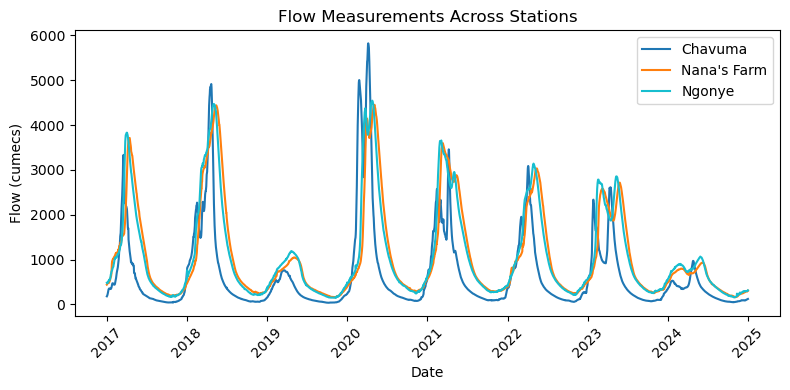

In [33]:
# Assuming 'zra' is the DataFrame containing the data
plt.figure(figsize=(8, 4))

# Plotting each station's flow data with improved colors
plt.plot(zra['Date'], zra['Flow_chavuma'], label='Chavuma', color='#1f77b4')  # Nice blue
plt.plot(zra['Date'], zra['Flow_nana'], label="Nana's Farm", color='#ff7f0e')        # Fresh green
plt.plot(zra['Date'], zra['Flow_ngonye'], label='Ngonye', color='#17becf')     # Light teal for a different greenish tone

# Adding title and labels
plt.title('Flow Measurements Across Stations')
plt.xlabel('Date')
plt.ylabel('Flow (cumecs)')

# Rotating the date labels for better readability
plt.xticks(rotation=45)

# Adding a legend to differentiate the stations
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

#### Lake Kariba Levels
Two vertical increases have been identified, which can be seen as outliers since the dam levels cannot rise and fall so fast. In this case measurements indicated a rise and fall of 2.5m within a day. These points have been removed from the dataset. 

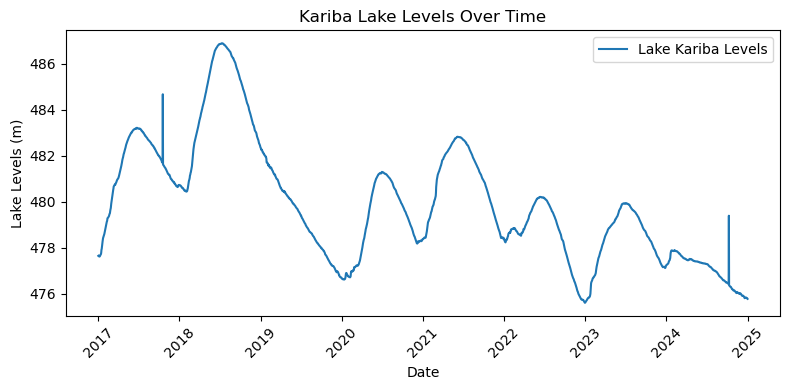

In [34]:
# Assuming 'zra' is the DataFrame containing the data
plt.figure(figsize=(8, 4))

# Plotting the last 50 entries of Kariba's flow data with an appropriate color
plt.plot(zra['Date'], zra['Level_kariba'], label='Lake Kariba Levels', color='#1f77b4')  # Nice blue for Kariba

# Adding title and labels specific to lake levels
plt.title('Kariba Lake Levels Over Time')
plt.xlabel('Date')
plt.ylabel('Lake Levels (m)')  # Change to 'Lake Levels' if using meters or similar unit

# Rotating the date labels for better readability
plt.xticks(rotation=45)

# Adding a legend for clarification
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


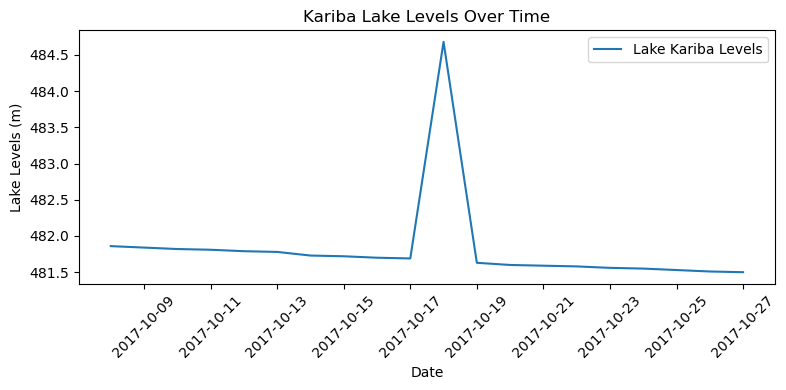

In [35]:
# Assuming 'zra' is the DataFrame containing the data
plt.figure(figsize=(8, 4))

# Plotting the last 50 entries of Kariba's flow data with an appropriate color
plt.plot(zra['Date'][280:300], zra['Level_kariba'][280:300], label='Lake Kariba Levels', color='#1f77b4')  # Nice blue for Kariba

# Adding title and labels specific to lake levels
plt.title('Kariba Lake Levels Over Time')
plt.xlabel('Date')
plt.ylabel('Lake Levels (m)')  # Change to 'Lake Levels' if using meters or similar unit

# Rotating the date labels for better readability
plt.xticks(rotation=45)

# Adding a legend for clarification
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [36]:
# Removing suspicious outliers
diffs = zra['Level_kariba'].diff() # Calculate daily differences

# Step 2: Find where the change is suspiciously high (e.g., over 2.4m in a single day)
suspicious_rises = diffs[diffs > 2.4].index

# Step 3: Interpolate those values with the average of the previous and next values
for idx in suspicious_rises:
    if idx - 1 in zra.index and idx + 1 in zra.index:
        prev_val = zra.loc[idx - 1, 'Level_kariba']
        next_val = zra.loc[idx + 1, 'Level_kariba']
        zra.loc[idx, 'Level_kariba'] = (prev_val + next_val) / 2

## Outlier Identification
The river flow data contains a number of outliers, which could be due to measurement errors, extreme weather events, or natural seasonal variations. A proper approach to handling these outliers depends on the context and the role of river flow in the model.

Since river overflows and droughts represent real-world events that could influence prices, removing these outliers outright is not ideal. Instead of eliminating high values, we retain them to allow the model to capture their potential impact.

To ensure stability during training, the river flow data will be normalized using Min-Max scaling to keep all variations while preventing extreme values from dominating the model. In cases where the data is highly skewed, a log transformation can help reduce the effect of extreme spikes while maintaining meaningful relationships.

While rolling averages or smoothing techniques could reduce short-term fluctuations, they may also remove crucial information about extreme river conditions. If additional data on rainfall or upstream conditions were available, a more robust model could differentiate between genuine peak flows and anomalies.

In [37]:
from scipy.stats import zscore

numeric_cols = ['Flow_chavuma', 'Level_kariba', 'Flow_nana', 'Flow_ngonye']
# Calculate the Z-scores for all columns in zra
z_scores = zra[numeric_cols].apply(zscore)

# Identify outliers where the absolute Z-score is greater than 3
outliers = (z_scores.abs() > 3).sum()

# Print the number of outliers per station
print("Number of outliers detected per station:\n", outliers)


Number of outliers detected per station:
 Flow_chavuma    74
Level_kariba     0
Flow_nana       33
Flow_ngonye     42
dtype: int64


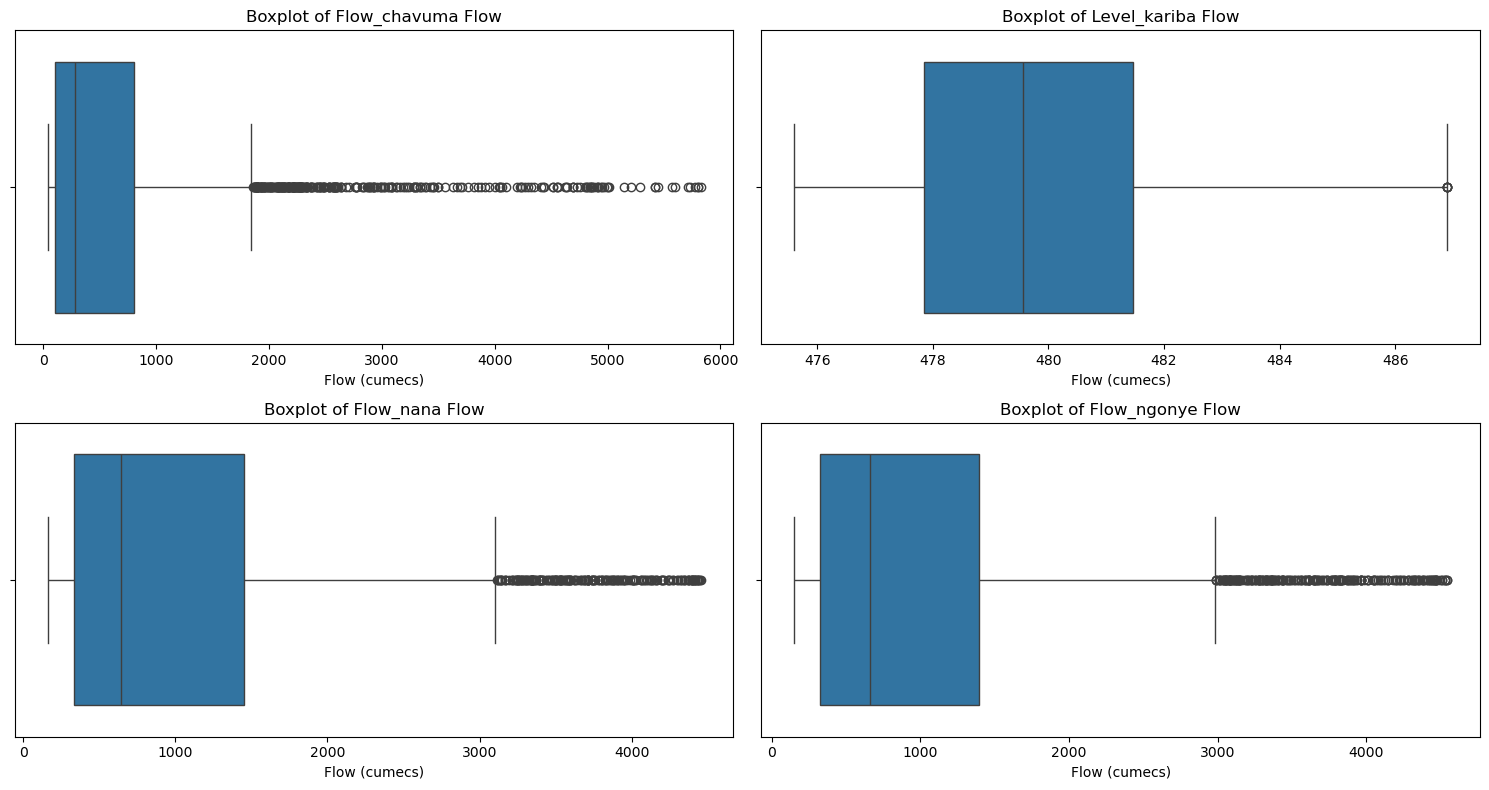

In [38]:
# Create subplots to place each boxplot separately
plt.figure(figsize=(15, 8))

# Plot boxplot for each station
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 2, i)  # 2x2 grid of subplots
    sns.boxplot(x=zra[col])
    plt.title(f"Boxplot of {col} Flow")
    plt.xlabel("Flow (cumecs)")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

### Normalisation
To ensure stability during training, different normalization techniques will be applied based on the distribution of each feature:

- Flow_chavuma has a long right-tailed distribution, so a log transformation will be applied to reduce skewness before normalization.

- Flow_nana, Flow_ngonye, and Level_kariba have fewer extreme outliers, so they will be scaled using Min-Max normalization to retain their full range while keeping values within a stable scale.

In [39]:
# Log Transformation
zra['Flow_chavuma'] = np.log1p(zra['Flow_chavuma'])  # log(1 + x) to handle zeros

# MinMax Scaling
scaler = MinMaxScaler()
zra[['Flow_chavuma', 'Flow_nana', 'Flow_ngonye', 'Level_kariba']] = scaler.fit_transform(
    zra[['Flow_chavuma', 'Flow_nana', 'Flow_ngonye', 'Level_kariba']]
)

In [40]:
zra.to_csv(f'{file_pattern_ZRA}/zra_cleaned.csv', index=False)

# Solar Generation Profile
This section processes data from the Tati Solar Generation Site in Botswana. The dataset includes values for Global Horizontal Irradiance (`GlobHor`), Diffuse Horizontal Irradiance (`DiffHor`), Ambient Temperature (`T_Amb`), Global Incidence (`GlobInc`), Array Power (`EArray`), Grid Power (`E_Grid`), and Performance Ratio (`PR`). The solar generation profile is based on long-term average data from Tati, covering the period from 1990 to last year—just over 30 years. While it would have been ideal to use actual year-by-year solar irradiation data, only the multi-year annual average was made available. Given the relatively consistent nature of solar irradiation over time, this long-term average provides a robust foundation for modeling. By adjusting the dates and replicating the average annual profile, the data has been extended to cover the full analysis period.

In [41]:
file_pattern_SGP = '../../Data/Solar Generation Profile'


## Tati Hourly
The tati_sgp dataset, containing solar generation data, was processed to ensure correct date formatting and alignment. Duplicates were removed, and the Hour column was integrated into the Date column, allowing for proper time-series representation. This ensured that the dataset contained unique hourly records for the entire year, making it ready for further analysis and merging with the adjusted tati_avg data.

In addition, In the dataset, variables representing **irradiance, energy, and performance ratio** should always be **absolute values**, as these physical quantities cannot be negative. This irregularity was present in `E_Grid (kW)`. To ensure correctness, the values of this have been converterd to 0. However, **ambient temperature** can naturally be negative in cold conditions, so it remains unchanged. This adjustment ensures that all measured values accurately reflect real-world conditions.

In [42]:
tati_sgp = pd.read_csv(
    f'{file_pattern_SGP}/Tati PV Project_VC0_HourlyRes_0.csv',
    delimiter=',',
    encoding='latin1',
    skiprows=11  # Adjust this number based on the number of metadata rows
)

# Rename the columns by combining the first two header rows
tati_sgp.columns = ['Date', 'GlobHor (W/m²)', 'DiffHor (W/m²)', 'T_Amb (°C)', 
              'GlobInc (W/m²)', 'EArray (kW)', 'E_Grid (kW)', 'PR (ratio)']

# Convert 'Date' column to datetime format
tati_sgp['Date'] = pd.to_datetime(tati_sgp['Date'], format='%d/%m/%y %H:%M', errors='coerce')

### Checking negative values

In [43]:
# Define columns to check for negative values
columns_to_check = ['GlobHor (W/m²)', 'DiffHor (W/m²)', 'GlobInc (W/m²)', 
                    'EArray (kW)', 'E_Grid (kW)', 'PR (ratio)']

# Check for negative values in each column
negative_check = {col: (tati_sgp[col] < 0).any() for col in columns_to_check}

# Display the results
negative_check


{'GlobHor (W/m²)': False,
 'DiffHor (W/m²)': False,
 'GlobInc (W/m²)': False,
 'EArray (kW)': False,
 'E_Grid (kW)': True,
 'PR (ratio)': False}

In [44]:
# Convert selected columns to 0
tati_sgp['E_Grid (kW)'] = tati_sgp['E_Grid (kW)'].clip(lower=0)

### Plotting values
We plot the first day (1990-01-01) to visually inspect the **hourly variations** of key variables throughout a typical 24-hour period. This helps to understand the **flow of data** and how the system behaves over the course of a day. For instance, during the **nighttime hours**, when there is no sunlight, variables like **irradiance and energy production** will naturally drop to zero. This is because these systems depend on solar input, which isn't available at night. By plotting the first day, we can easily observe how variables such as **global horizontal irradiance**, **energy from the array**, and **performance ratio** follow the natural cycle of the sun, showing peaks during the day and a complete drop-off at night. This visual representation also helps us confirm that the dataset behaves realistically, with no unexpected values during the nighttime.

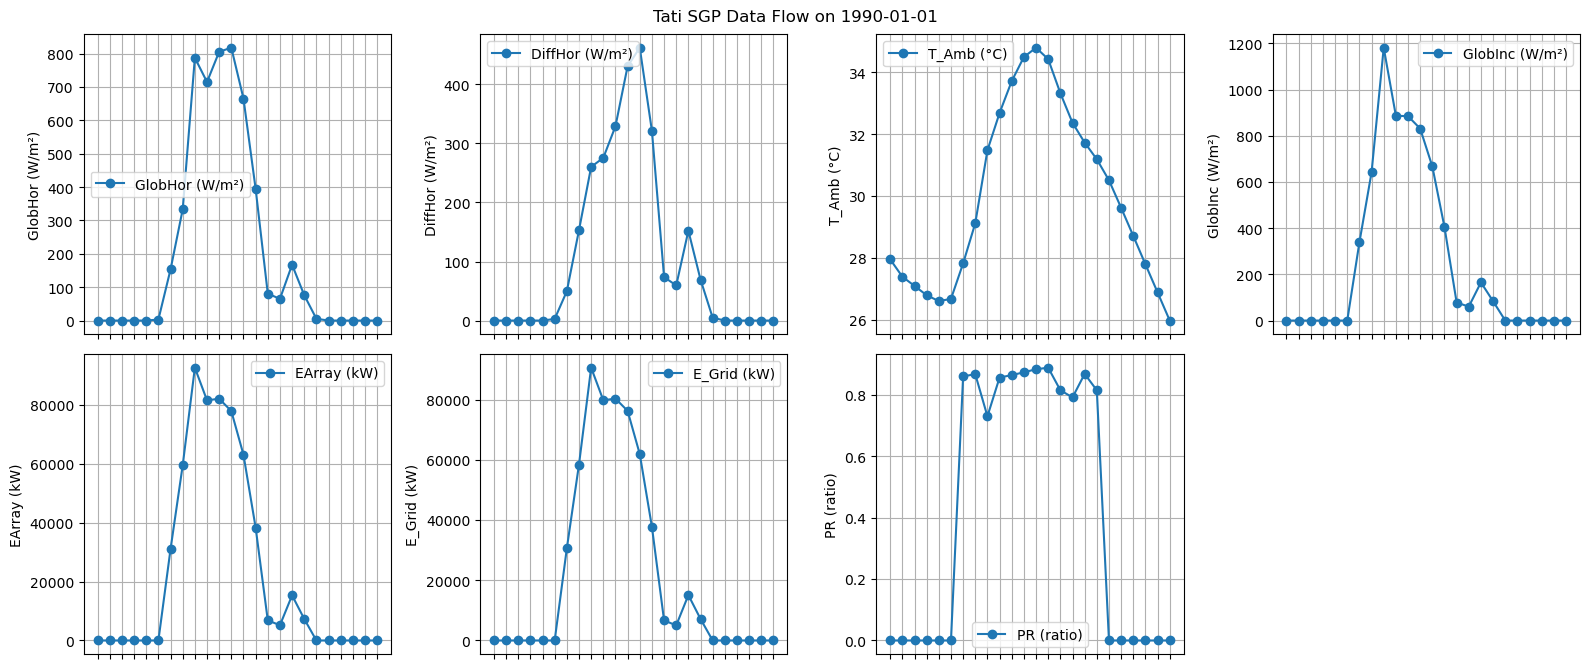

In [45]:
# Ensure 'Date' is in datetime format
tati_sgp['Date'] = pd.to_datetime(tati_sgp['Date'])

# Filter data for the first day (1990-01-01)
first_day = tati_sgp[tati_sgp['Date'].dt.date == pd.to_datetime('1990-01-01').date()].copy()

# Convert 'Date' column to time in string format for plotting
first_day['Time'] = first_day['Date'].dt.strftime('%H:%M')

# Define columns to plot
columns_to_plot = ['GlobHor (W/m²)', 'DiffHor (W/m²)', 'T_Amb (°C)', 'GlobInc (W/m²)', 
                   'EArray (kW)', 'E_Grid (kW)', 'PR (ratio)']

# Create a 3x4 grid layout
fig, axes = plt.subplots(3, 4, figsize=(16, 10), sharex=True)
axes = axes.flatten()  # Flatten to easily iterate over

# Plot each column in a separate subplot
for i, col in enumerate(columns_to_plot):
    axes[i].plot(first_day['Time'], first_day[col], marker='o', linestyle='-', label=col, color='tab:blue')
    axes[i].set_ylabel(col)
    axes[i].legend()
    axes[i].grid(True)

# Hide any unused subplots (since we have only 7 variables but a 3x4 grid = 12 slots)
for j in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[j])  # Remove empty subplots for a cleaner look

# Set common x-axis label and title
axes[-1].set_xlabel('Time of Day')
fig.suptitle('Tati SGP Data Flow on 1990-01-01')

# Improve x-axis readability
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()


### Expanding Tati
Tati was originally a dataset from 1990, meaning it did not include leap years beyond that point. To expand it for the years 2017 to 2024, we iteratively duplicated the original data while adjusting the year in each entry. Since 1990 was not a leap year, February 29 was missing from the dataset. To properly account for leap years, we manually added February 29 for 2020 and 2024 by duplicating the February 28 data while preserving the time structure. This is done at a later stage after merging `tati_sgp` with `tati_avg`. This ensured that the expanded dataset accurately reflected the expected calendar structure for each year.

In [46]:
# Create a list of years to repeat (2017 to 2024)
years = range(2017, 2025)

# Create an empty list to hold the new DataFrames
expanded_data = []

# Loop over each year and adjust the Date column
for year in years:
    # Create a copy of the original data and change the year in the 'Date' column
    data_copy = tati_sgp.copy()
    data_copy['Date'] = data_copy['Date'].apply(lambda x: x.replace(year=year))
    expanded_data.append(data_copy)

# Concatenate the DataFrames into one DataFrame
expanded_tati_sgp = pd.concat(expanded_data, ignore_index=True)


In [47]:
expanded_tati_sgp

Date  GlobHor (W/m²)  DiffHor (W/m²)  T_Amb (°C)  \
0     2017-01-01 00:00:00             0.0             0.0       27.95   
1     2017-01-01 01:00:00             0.0             0.0       27.39   
2     2017-01-01 02:00:00             0.0             0.0       27.09   
3     2017-01-01 03:00:00             0.0             0.0       26.79   
4     2017-01-01 04:00:00             0.0             0.0       26.60   
...                   ...             ...             ...         ...   
70075 2024-12-31 19:00:00             0.0             0.0       26.15   
70076 2024-12-31 20:00:00             0.0             0.0       24.89   
70077 2024-12-31 21:00:00             0.0             0.0       23.54   
70078 2024-12-31 22:00:00             0.0             0.0       22.01   
70079 2024-12-31 23:00:00             0.0             0.0       20.84   

       GlobInc (W/m²)  EArray (kW)  E_Grid (kW)  PR (ratio)  
0                 0.0          0.0          0.0         0.0  
1                 0.0          0.0          0.0         0.0  
2                 0.0          0.0          0.0         0.0  
3                 0.0          0.0          0.0         0.0  
4                 0.0          0.0          0.0         0.0  
...               ...          ...          ...         ...  
70075             0.0          0.0          0.0         0.0  
70076             0.0          0.0          0.0         0.0  
70077             0.0          0.0          0.0         0.0  
70078             0.0          0.0          0.0         0.0  
70079             0.0          0.0          0.0         0.0  

[70080 rows x 8 columns]

## Tati Average Output
The dataset, containing the Average Output (AO) for the Tati site, was reshaped from a wide to a long format. A Year column was added, and corresponding Date values were generated by combining Month and Hour. This allowed the solar generation data to be repeated for each day of the year, resulting in a complete date-time column for each hourly generation value.

In [48]:
# Specify the range of columns
columns_to_read = list(range(7, 20))  # This creates a list of column indices from 7 to 19

tati_avg = pd.read_csv(f'{file_pattern_SGP}/231103_Tati_PV_Profile.csv', delimiter=';', skiprows=3, usecols=columns_to_read)

# Filter the DataFrame to keep only rows where 'Hour' is numeric and less than 23
tati_avg = tati_avg[tati_avg['Hour'].apply(pd.to_numeric, errors='coerce').notna()]
tati_avg

Hour    Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct  \
0     0   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   
1     1   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   
2     2   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   
3     3   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   
4     4   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   
5     5   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   
6     6  19,9%   4,7%   0,8%   0,0%   0,0%   0,0%   0,0%   0,0%   3,8%  26,1%   
7     7  53,6%  41,6%  40,9%  39,3%  31,7%  19,8%  19,8%  33,3%  48,6%  66,3%   
8     8  63,2%  56,5%  63,6%  64,6%  66,5%  54,4%  58,8%  69,9%  70,1%  73,3%   
9     9  67,6%  62,6%  66,8%  70,3%  68,8%  57,4%  63,0%  74,5%  74,2%  75,4%   
10   10  75,7%  66,7%  70,0%  68,3%  69,4%  59,2%  64,9%  76,6%  78,3%  78,5%   
11   11  71,6%  66,5%  64,1%  69,6%  68,6%  61,1%  65,1%  74,7%  72,9%  75,6%   
12   12  67,1%  66,9%  64,1%  66,8%  67,4%  60,9%  66,4%  75,1%  72,6%  74,3%   
13   13  65,5%  67,0%  63,1%  65,9%  66,4%  62,9%  66,5%  73,8%  72,5%  73,0%   
14   14  62,4%  62,8%  63,6%  62,4%  66,1%  61,8%  66,0%  72,7%  69,5%  71,9%   
15   15  57,7%  64,3%  59,9%  59,8%  62,3%  58,5%  62,9%  70,2%  66,1%  67,6%   
16   16  52,6%  60,0%  52,5%  45,8%  36,9%  32,8%  40,3%  44,6%  47,9%  59,4%   
17   17  33,6%  35,3%  17,0%   2,7%   0,0%   0,0%   0,1%   0,9%   3,2%   7,9%   
18   18   1,0%   0,5%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   
19   19   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   
20   20   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   
21   21   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   
22   22   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   
23   23   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   0,0%   

      Nov    Dec  
0    0,0%   0,0%  
1    0,0%   0,0%  
2    0,0%   0,0%  
3    0,0%   0,0%  
4    0,0%   0,0%  
5    0,0%   0,0%  
6   30,7%  29,3%  
7   60,2%  56,3%  
8   65,5%  62,7%  
9   69,7%  66,7%  
10  72,1%  68,3%  
11  69,2%  64,8%  
12  70,9%  64,5%  
13  69,0%  64,7%  
14  64,7%  61,3%  
15  60,2%  57,6%  
16  52,8%  51,4%  
17  19,4%  30,0%  
18   0,0%   0,3%  
19   0,0%   0,0%  
20   0,0%   0,0%  
21   0,0%   0,0%  
22   0,0%   0,0%  
23   0,0%   0,0%

In [49]:
# Melt the DataFrame to long format
tati_avg_melted = tati_avg.melt(id_vars=["Hour"], var_name="Month", value_name="AO (in %)")
tati_avg_melted['AO (in %)'] = tati_avg_melted['AO (in %)'].str.replace(',', '.').str.replace('%', '').astype(float) / 100
# # Set a year for the data (assuming 1990 or the desired year)
tati_avg_melted['Year'] = 1990  # Or the year you want to assume

# Create a dictionary with the number of days in each month
months = {'Jan': 31, 'Feb': 28, 'Mar': 31, 'Apr': 30, 'May': 31, 'Jun': 30, 'Jul': 31, 
          'Aug': 31, 'Sep': 30, 'Oct': 31, 'Nov': 30, 'Dec': 31}

expanded_data = []

# Loop through each month to expand data
for month, days in months.items():
    # Generate the date range for the month (one date per day)
    month_dates = pd.date_range(f'{tati_avg_melted["Year"].iloc[0]}-{month}-01', periods=days, freq='D')
    
    # Filter data for the current month
    month_data = tati_avg_melted[tati_avg_melted['Month'] == month].copy()

    # Repeat the data for each hour in the day
    for day in month_dates:
        # Repeat the hour 24 times for the current day
        day_data = month_data.copy()
        day_data['Date'] = [day] * len(day_data)  # Assign the same date for each row
        
        # Append the day_data to expanded_data
        expanded_data.append(day_data)

# Concatenate all the data for each month and day into one DataFrame
tati_1990 = pd.concat(expanded_data, ignore_index=True)

# Include the Hour in the Date
tati_1990['Date'] = pd.to_datetime(tati_1990['Date'].astype(str) + ' ' + tati_1990['Hour'].astype(str) + ':00', format='%Y-%m-%d %H:%M')
tati_1990 = tati_1990[['Date','AO (in %)']]
tati_1990

Date  AO (in %)
0    1990-01-01 00:00:00        0.0
1    1990-01-01 01:00:00        0.0
2    1990-01-01 02:00:00        0.0
3    1990-01-01 03:00:00        0.0
4    1990-01-01 04:00:00        0.0
...                  ...        ...
8755 1990-12-31 19:00:00        0.0
8756 1990-12-31 20:00:00        0.0
8757 1990-12-31 21:00:00        0.0
8758 1990-12-31 22:00:00        0.0
8759 1990-12-31 23:00:00        0.0

[8760 rows x 2 columns]

### Plotting Tati Monthly Average Output
In this analysis, we plotted the **first day of each month** for four specific months: **July and August** (winter months) and **November and December** (summer months), using a **2x2 subplot layout**. For each of these months, we visualized the **hourly AO (in %)** values, showing how the output varies throughout the day. The winter months (July and August) are plotted in **blue**, and the summer months (November and December) are plotted in **red**. Notably, the winter months exhibit a **higher range of AO** values, likely due to more stable sunlight conditions, while the summer months show a more restricted variation in output. This helps highlight the seasonal differences in solar energy production.

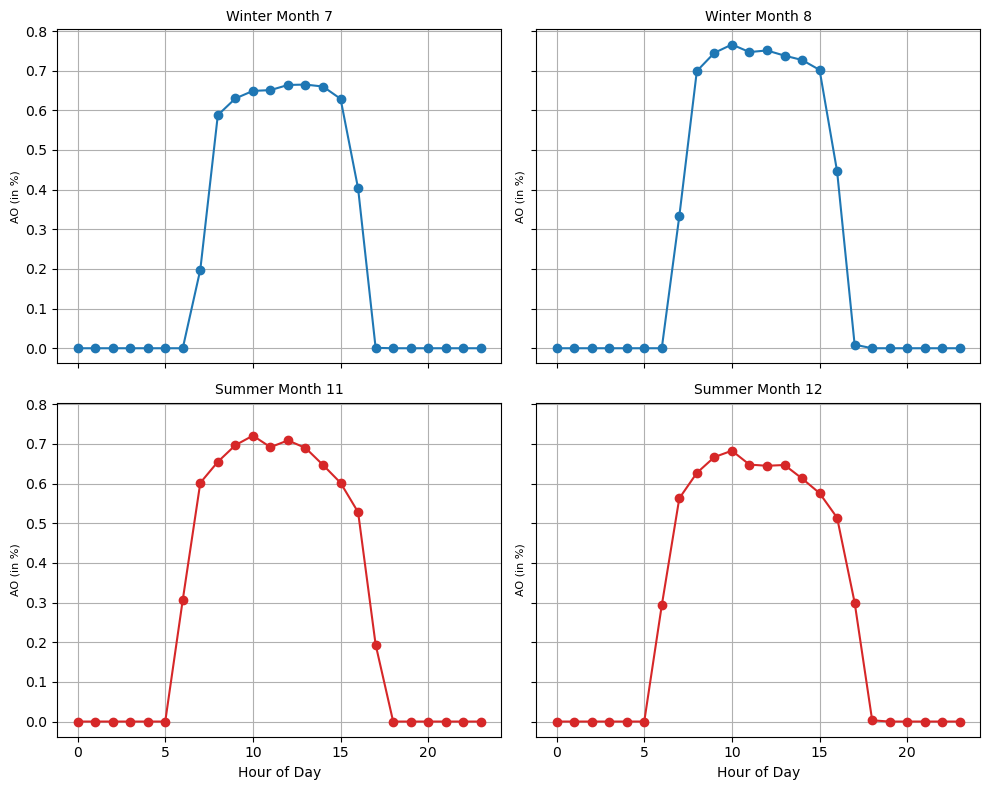

In [50]:
# Assuming tati_1990 is already loaded with Date and AO columns
tati_1990['Date'] = pd.to_datetime(tati_1990['Date'])

# Extract month and hour for grouping
tati_1990['Month'] = tati_1990['Date'].dt.month
tati_1990['Hour'] = tati_1990['Date'].dt.hour

# Define winter and summer months
winter_months = [7, 8]  # July, August
summer_months = [11, 12]  # November, December

# Initialize the figure for 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)

# Flatten axes for easy iteration
axes = axes.flatten()

# Loop through the winter and summer months and plot the first day's hourly data
for i, month in enumerate(winter_months + summer_months):
    # Filter the data to get the first day of the current month
    first_day_data = tati_1990[(tati_1990['Month'] == month) & (tati_1990['Date'].dt.day == 14)]

    # Ensure the data contains exactly 24 hours (one for each hour of the day)
    if len(first_day_data) == 24:
        if month in winter_months:
            axes[i].plot(first_day_data['Hour'], first_day_data['AO (in %)'], marker='o', linestyle='-', color='tab:blue')
            axes[i].set_title(f'Winter Month {month}', fontsize=10)
        elif month in summer_months:
            axes[i].plot(first_day_data['Hour'], first_day_data['AO (in %)'], marker='o', linestyle='-', color='tab:red')
            axes[i].set_title(f'Summer Month {month}', fontsize=10)

        axes[i].set_ylabel('AO (in %)', fontsize=8)
        axes[i].grid(True)

# Set the x-axis label for the bottom row
for ax in axes[2:]:
    ax.set_xlabel('Hour of Day', fontsize=10)

# Adjust the layout for better spacing
plt.tight_layout()
plt.show()


## Merging the Generation Profile with the Monthly Average Output
Combining both datasets and expanding the date ranges from 2017 to 2024

In [51]:
# Merge tati_sgp and tati_1990 on the 'Date' column
tati_merged = pd.merge(tati_sgp, tati_1990, on='Date', how='left')

In [52]:
# Create a list of years to repeat (2017 to 2024)
years = range(2017, 2025)

# Create an empty list to hold the new DataFrames
expanded_data = []

# Loop over each year and adjust the Date column
for year in years:
    # Create a copy of the original data and change the year in the 'Date' column
    data_copy = tati_merged.copy()
    data_copy['Date'] = data_copy['Date'].apply(lambda x: x.replace(year=year))
    expanded_data.append(data_copy)

# Concatenate the DataFrames into one DataFrame
expanded_tati = pd.concat(expanded_data, ignore_index=True)
expanded_tati

Date  GlobHor (W/m²)  DiffHor (W/m²)  T_Amb (°C)  \
0     2017-01-01 00:00:00             0.0             0.0       27.95   
1     2017-01-01 01:00:00             0.0             0.0       27.39   
2     2017-01-01 02:00:00             0.0             0.0       27.09   
3     2017-01-01 03:00:00             0.0             0.0       26.79   
4     2017-01-01 04:00:00             0.0             0.0       26.60   
...                   ...             ...             ...         ...   
70075 2024-12-31 19:00:00             0.0             0.0       26.15   
70076 2024-12-31 20:00:00             0.0             0.0       24.89   
70077 2024-12-31 21:00:00             0.0             0.0       23.54   
70078 2024-12-31 22:00:00             0.0             0.0       22.01   
70079 2024-12-31 23:00:00             0.0             0.0       20.84   

       GlobInc (W/m²)  EArray (kW)  E_Grid (kW)  PR (ratio)  AO (in %)  Month  \
0                 0.0          0.0          0.0         0.0        0.0      1   
1                 0.0          0.0          0.0         0.0        0.0      1   
2                 0.0          0.0          0.0         0.0        0.0      1   
3                 0.0          0.0          0.0         0.0        0.0      1   
4                 0.0          0.0          0.0         0.0        0.0      1   
...               ...          ...          ...         ...        ...    ...   
70075             0.0          0.0          0.0         0.0        0.0     12   
70076             0.0          0.0          0.0         0.0        0.0     12   
70077             0.0          0.0          0.0         0.0        0.0     12   
70078             0.0          0.0          0.0         0.0        0.0     12   
70079             0.0          0.0          0.0         0.0        0.0     12   

       Hour  
0         0  
1         1  
2         2  
3         3  
4         4  
...     ...  
70075    19  
70076    20  
70077    21  
70078    22  
70079    23  

[70080 rows x 11 columns]

Since Tati was manually created, leap years should be properly accounted for. This is achieved by including February 29 for the years 2020 and 2024 by duplicating the data from February 28 of those years while preserving the original timestamps, ensuring continuity in the dataset.

In [53]:
# Filter rows where Date is 2020-02-28 (ignoring time part)
feb_28_rows_2020 = expanded_tati[expanded_tati['Date'].dt.date == pd.to_datetime('2020-02-28').date()]
feb_28_rows_2024 = expanded_tati[expanded_tati['Date'].dt.date == pd.to_datetime('2024-02-28').date()]

# Duplicate these rows and change the Date to 2020-02-29
feb_29_rows_2020 = feb_28_rows_2020.copy()
feb_29_rows_2020['Date'] = feb_29_rows_2020['Date'].apply(lambda x: x.replace(day=29))  # Keep time intact

# Duplicate these rows and change the Date to 2024-02-29
feb_29_rows_2024 = feb_28_rows_2024.copy()
feb_29_rows_2024['Date'] = feb_29_rows_2024['Date'].apply(lambda x: x.replace(day=29))  # Keep time intact

# Concatenate the new rows with the expanded_tati dataset
expanded_tati_with_feb29 = pd.concat([expanded_tati, feb_29_rows_2020], ignore_index=True)
expanded_tati_with_feb29 = pd.concat([expanded_tati_with_feb29, feb_29_rows_2024], ignore_index=True)

# # Now, expanded_tati_with_feb29 has the duplicated rows for 2020-02-29
expanded_tati_with_feb29[expanded_tati_with_feb29['Date'].dt.date == pd.to_datetime('2024-02-29').date()]

Date  GlobHor (W/m²)  DiffHor (W/m²)  T_Amb (°C)  \
70104 2024-02-29 00:00:00          0.0000          0.0000       23.54   
70105 2024-02-29 01:00:00          0.0000          0.0000       22.52   
70106 2024-02-29 02:00:00          0.0000          0.0000       21.51   
70107 2024-02-29 03:00:00          0.0000          0.0000       20.97   
70108 2024-02-29 04:00:00          0.0000          0.0000       20.44   
70109 2024-02-29 05:00:00          0.0000          0.0000       20.05   
70110 2024-02-29 06:00:00         20.6960         20.5030       20.41   
70111 2024-02-29 07:00:00        269.5100        118.7000       22.86   
70112 2024-02-29 08:00:00        517.2100         88.9040       25.31   
70113 2024-02-29 09:00:00        730.2000        136.0000       27.54   
70114 2024-02-29 10:00:00        885.3900        200.5000       29.44   
70115 2024-02-29 11:00:00        979.0900        249.8000       30.99   
70116 2024-02-29 12:00:00       1000.2000        280.0000       32.14   
70117 2024-02-29 13:00:00        956.6100        249.5000       32.88   
70118 2024-02-29 14:00:00        844.6900        196.6000       33.19   
70119 2024-02-29 15:00:00        672.6000        134.4000       33.07   
70120 2024-02-29 16:00:00        454.0000         83.2030       32.30   
70121 2024-02-29 17:00:00        209.0100         54.9990       30.97   
70122 2024-02-29 18:00:00          6.6071          6.6009       29.31   
70123 2024-02-29 19:00:00          0.0000          0.0000       28.07   
70124 2024-02-29 20:00:00          0.0000          0.0000       26.83   
70125 2024-02-29 21:00:00          0.0000          0.0000       25.56   
70126 2024-02-29 22:00:00          0.0000          0.0000       24.28   
70127 2024-02-29 23:00:00          0.0000          0.0000       23.00   

       GlobInc (W/m²)  EArray (kW)  E_Grid (kW)  PR (ratio)  AO (in %)  Month  \
70104           0.000          0.0          0.0      0.0000      0.000      2   
70105           0.000          0.0          0.0      0.0000      0.000      2   
70106           0.000          0.0          0.0      0.0000      0.000      2   
70107           0.000          0.0          0.0      0.0000      0.000      2   
70108           0.000          0.0          0.0      0.0000      0.000      2   
70109           0.000          0.0          0.0      0.0000      0.000      2   
70110          19.683       1531.3       1182.6      0.5722      0.047      2   
70111         561.160      53268.0      52401.0      0.8893      0.416      2   
70112         957.090      87630.0      85737.0      0.8531      0.565      2   
70113        1011.800      92784.0      90702.0      0.8537      0.626      2   
70114        1024.900      93814.0      91724.0      0.8523      0.667      2   
70115        1017.100      92969.0      90910.0      0.8512      0.665      2   
70116        1003.800      91988.0      89957.0      0.8535      0.669      2   
70117        1015.800      91353.0      89349.0      0.8377      0.670      2   
70118        1018.100      91095.0      89084.0      0.8333      0.628      2   
70119         991.110      88708.0      86744.0      0.8335      0.643      2   
70120         926.960      82259.0      80519.0      0.8272      0.600      2   
70121         481.920      43442.0      42772.0      0.8453      0.353      2   
70122           0.000          0.0          0.0      0.0000      0.005      2   
70123           0.000          0.0          0.0      0.0000      0.000      2   
70124           0.000          0.0          0.0      0.0000      0.000      2   
70125           0.000          0.0          0.0      0.0000      0.000      2   
70126           0.000          0.0          0.0      0.0000      0.000      2   
70127           0.000          0.0          0.0      0.0000      0.000      2   

       Hour  
70104     0  
70105     1  
70106     2  
70107     3  
70108     4  
70109     5  
70110     6  
70111     7  
70112     8  
70113     9  
70114    10  
7

# Combining All Datasets
Here we will merge the data of the DAM prices, ZRA and Solar Generation Profile. Initially the first two datasets will be merged by Date and DeliveryHour. The Date will become a datetime object s.t. the Solar Generation Profile can be included by merging on the Date (with the time).

In [54]:
# Repeat each row 24 times to match df_DAM
zra_expanded = zra.loc[zra.index.repeat(24)].reset_index(drop=True)

# Ensure 'Date' column is in datetime format
zra_expanded['Date'] = pd.to_datetime(zra_expanded['Date'])

# Create a 'DeliveryHour' column (0 to 23 for each day)
zra_expanded['DeliveryHour'] = [hour for hour in range(24)] * len(zra)

In [55]:
# Rename column for consisteny
df_DAM = df_DAM.rename(columns={'DeliveryDay': 'Date'})
df_DAM.reset_index(drop=True,inplace=True)

# Ensure 'DeliveryDay' in df_DAM and 'Date' in zra_expanded are in datetime format
df_DAM['Date'] = pd.to_datetime(df_DAM['Date'])

In [56]:
# Merge on date and delivery hour
merged_dam_zra = pd.merge(df_DAM, zra_expanded, on=['Date', 'DeliveryHour'], how='left')

# Convert Date to full date
merged_dam_zra['Date'] = pd.to_datetime(merged_dam_zra['Date'].astype(str) + ' ' + merged_dam_zra['DeliveryHour'].astype(str) + ':00', format='%Y-%m-%d %H:%M')

# Drop unnecessary columns: 'DeliveryHour', 'Year', 'Month', 'Day'
merged_dam_zra.drop(columns=['DeliveryHour', 'Year', 'Month', 'Day'], inplace=True)
merged_dam_zra


Date  Price (USD/MWh)  Tati- normalised output  \
0     2017-01-01 00:00:00            31.97                      0.0   
1     2017-01-01 01:00:00            31.79                      0.0   
2     2017-01-01 02:00:00            31.75                      0.0   
3     2017-01-01 03:00:00            31.76                      0.0   
4     2017-01-01 04:00:00            31.72                      0.0   
...                   ...              ...                      ...   
70123 2024-12-31 19:00:00           347.10                      0.0   
70124 2024-12-31 20:00:00           343.17                      0.0   
70125 2024-12-31 21:00:00           249.15                      0.0   
70126 2024-12-31 22:00:00           107.92                      0.0   
70127 2024-12-31 23:00:00           106.00                      0.0   

       E_Grid (Mw)  Revenues (USD)  Volatility_1 Day  Volatility_3 Days  \
0              0.0             0.0          0.000000           0.000000   
1              0.0             0.0          0.000000           0.000000   
2              0.0             0.0          0.000000           0.000000   
3              0.0             0.0          0.000000           0.000000   
4              0.0             0.0          0.000000           0.000000   
...            ...             ...               ...                ...   
70123          0.0             0.0         94.337837          94.433386   
70124          0.0             0.0         93.951366          94.318913   
70125          0.0             0.0         93.970908          94.392915   
70126          0.0             0.0         93.217461          94.429037   
70127          0.0             0.0         92.326909          94.542641   

       Volatility_7 Days  Volatility_30 Days  Flow_chavuma  Level_kariba  \
0               0.000000            0.000000      0.305269      0.180531   
1               0.000000            0.000000      0.305269      0.180531   
2               0.000000            0.000000      0.305269      0.180531   
3               0.000000            0.000000      0.305269      0.180531   
4               0.000000            0.000000      0.305269      0.180531   
...                  ...                 ...           ...           ...   
70123          82.913752           98.527158      0.228747      0.015044   
70124          82.720682           98.711067      0.228747      0.015044   
70125          82.724460           98.714394      0.228747      0.015044   
70126          82.720166           98.687573      0.228747      0.015044   
70127          82.707399           98.666584      0.228747      0.015044   

       Flow_nana  Flow_ngonye  
0       0.065688     0.076223  
1       0.065688     0.076223  
2       0.065688     0.076223  
3       0.065688     0.076223  
4       0.065688     0.076223  
...          ...          ...  
70123   0.034475     0.037315  
70124   0.034475     0.037315  
70125   0.034475     0.037315  
70126   0.034475     0.037315  
70127   0.034475     0.037315  

[70128 rows x 13 columns]

In [57]:
zra_sgp_dam = pd.merge(merged_dam_zra, expanded_tati_with_feb29, on=['Date'], how='left')

# Final Dataset

In [58]:
# Including small variables, such as weekend, lag, momentum, rate-of-change
zra_sgp_dam['day_of_week'] = zra_sgp_dam['Date'].dt.dayofweek
zra_sgp_dam['is_weekend'] = zra_sgp_dam['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)  # Weekend indicator

# Create lag features and fill NaN values with the actual 'Price (USD/MWh)'
zra_sgp_dam['price_lag1d'] = zra_sgp_dam['Price (USD/MWh)'].shift(24)
zra_sgp_dam['price_lag1d'] = zra_sgp_dam['price_lag1d'].fillna(zra_sgp_dam['Price (USD/MWh)'])  # Fill with actual price for 1-day lag

zra_sgp_dam['price_lag7d'] = zra_sgp_dam['Price (USD/MWh)'].shift(168)
zra_sgp_dam['price_lag7d'] = zra_sgp_dam['price_lag7d'].fillna(zra_sgp_dam['Price (USD/MWh)'])  # Fill with actual price for 7-day lag

zra_sgp_dam['price_lag14d'] = zra_sgp_dam['Price (USD/MWh)'].shift(336)
zra_sgp_dam['price_lag14d'] = zra_sgp_dam['price_lag14d'].fillna(zra_sgp_dam['Price (USD/MWh)'])  # Fill with actual price for 7-day lag

# Calculate EMA and fill NaN values with actual price
zra_sgp_dam['ema_22h'] = zra_sgp_dam['Price (USD/MWh)'].ewm(span=22).mean()
zra_sgp_dam['ema_22h'] = zra_sgp_dam['ema_22h'].fillna(zra_sgp_dam['Price (USD/MWh)'])  # Fill NaN in EMA with actual price

zra_sgp_dam['ema_168h'] = zra_sgp_dam['Price (USD/MWh)'].ewm(span=168).mean()
zra_sgp_dam['ema_168h'] = zra_sgp_dam['ema_168h'].fillna(zra_sgp_dam['Price (USD/MWh)'])  # Fill NaN in EMA with actual price

# Calculate rate of change and handle infinities
zra_sgp_dam['roc_49h'] = zra_sgp_dam['Price (USD/MWh)'].pct_change(periods=49)
zra_sgp_dam['roc_49h'] = zra_sgp_dam['roc_49h'].replace([np.inf, -np.inf], np.nan)  # Replace inf with NaN
zra_sgp_dam['roc_49h'] = zra_sgp_dam['roc_49h'].fillna(zra_sgp_dam['Price (USD/MWh)'])  # Fill NaN in ROC with actual price

# Calculate momentum and fill NaN values with actual price
zra_sgp_dam['momentum_49h'] = zra_sgp_dam['Price (USD/MWh)'].shift(49)
zra_sgp_dam['momentum_49h'] = zra_sgp_dam['momentum_49h'].fillna(zra_sgp_dam['Price (USD/MWh)'])  # Fill NaN in momentum with actual price


In [66]:
file = '../../Data'
zra_sgp_dam.to_csv(f'{file}/zra_sgp_dam.csv', index=False)

In [60]:
zra_sgp_dam

Date  Price (USD/MWh)  Tati- normalised output  \
0     2017-01-01 00:00:00            31.97                      0.0   
1     2017-01-01 01:00:00            31.79                      0.0   
2     2017-01-01 02:00:00            31.75                      0.0   
3     2017-01-01 03:00:00            31.76                      0.0   
4     2017-01-01 04:00:00            31.72                      0.0   
...                   ...              ...                      ...   
70123 2024-12-31 19:00:00           347.10                      0.0   
70124 2024-12-31 20:00:00           343.17                      0.0   
70125 2024-12-31 21:00:00           249.15                      0.0   
70126 2024-12-31 22:00:00           107.92                      0.0   
70127 2024-12-31 23:00:00           106.00                      0.0   

       E_Grid (Mw)  Revenues (USD)  Volatility_1 Day  Volatility_3 Days  \
0              0.0             0.0          0.000000           0.000000   
1              0.0             0.0          0.000000           0.000000   
2              0.0             0.0          0.000000           0.000000   
3              0.0             0.0          0.000000           0.000000   
4              0.0             0.0          0.000000           0.000000   
...            ...             ...               ...                ...   
70123          0.0             0.0         94.337837          94.433386   
70124          0.0             0.0         93.951366          94.318913   
70125          0.0             0.0         93.970908          94.392915   
70126          0.0             0.0         93.217461          94.429037   
70127          0.0             0.0         92.326909          94.542641   

       Volatility_7 Days  Volatility_30 Days  Flow_chavuma  ...  Hour  \
0               0.000000            0.000000      0.305269  ...     0   
1               0.000000            0.000000      0.305269  ...     1   
2               0.000000            0.000000      0.305269  ...     2   
3               0.000000            0.000000      0.305269  ...     3   
4               0.000000            0.000000      0.305269  ...     4   
...                  ...                 ...           ...  ...   ...   
70123          82.913752           98.527158      0.228747  ...    19   
70124          82.720682           98.711067      0.228747  ...    20   
70125          82.724460           98.714394      0.228747  ...    21   
70126          82.720166           98.687573      0.228747  ...    22   
70127          82.707399           98.666584      0.228747  ...    23   

       day_of_week  is_weekend  price_lag1d  price_lag7d  price_lag14d  \
0                6           1        31.97        31.97         31.97   
1                6           1        31.79        31.79         31.79   
2                6           1        31.75        31.75         31.75   
3                6           1        31.76        31.76         31.76   
4                6           1        31.72        31.72         31.72   
...            ...         ...          ...          ...           ...   
70123            1           0       347.15       355.79        370.07   
70124            1           0       347.15       355.79        370.07   
70125            1           0       248.78       248.68        370.07   
70126            1           0       195.25       106.00        198.98   
70127            1           0       195.25       100.88        178.87   

          ema_22h    ema_168h    roc_49h  momentum_49h  
0       31.970000   31.970000  31.970000         31.97  
1       31.875909   31.879464  31.790000         31.79  
2       31.830069   31.835795  31.750000         31.75  
3       31.810094   31.816506  31.760000         31.76  
4       31.788657   31.796743  31.720000         31.72  
...           ...         ...        ...           ...  
70123  148.227339  147.091295   0.161025        298.96  
70124  165.178875  149.411753   0.147803     

Visualizing the relationship between the target and the rest of the variables.
The scatter plot matrix reveals diverse relationships between various features and electricity prices (USD/MWh). Notably, volatility indicators—especially at 1-day and 3-day lags—display a moderately positive correlation with price, suggesting that periods of high market uncertainty often coincide with price spikes. Hydrological variables such as Flow_kariba, Level_kariba, and Flow_nana exhibit more dispersed relationships, indicating potential but weak influence on price dynamics. Solar-related factors, including Globhor, Diffhor, and Earray, show wide scatter, implying limited direct impact or the need for further feature engineering to capture their effect. Variables like Tati normalised output and E_Grid hint at mild positive associations with price, possibly reflecting demand-side influences. In contrast, operational metrics such as PR (Performance Ratio) and AO (Availability) appear to have minimal visible correlation with price. Overall, the data suggests that while some features hold predictive potential, many relationships are complex and likely non-linear, warranting deeper statistical analysis or machine learning approaches for accurate modeling.

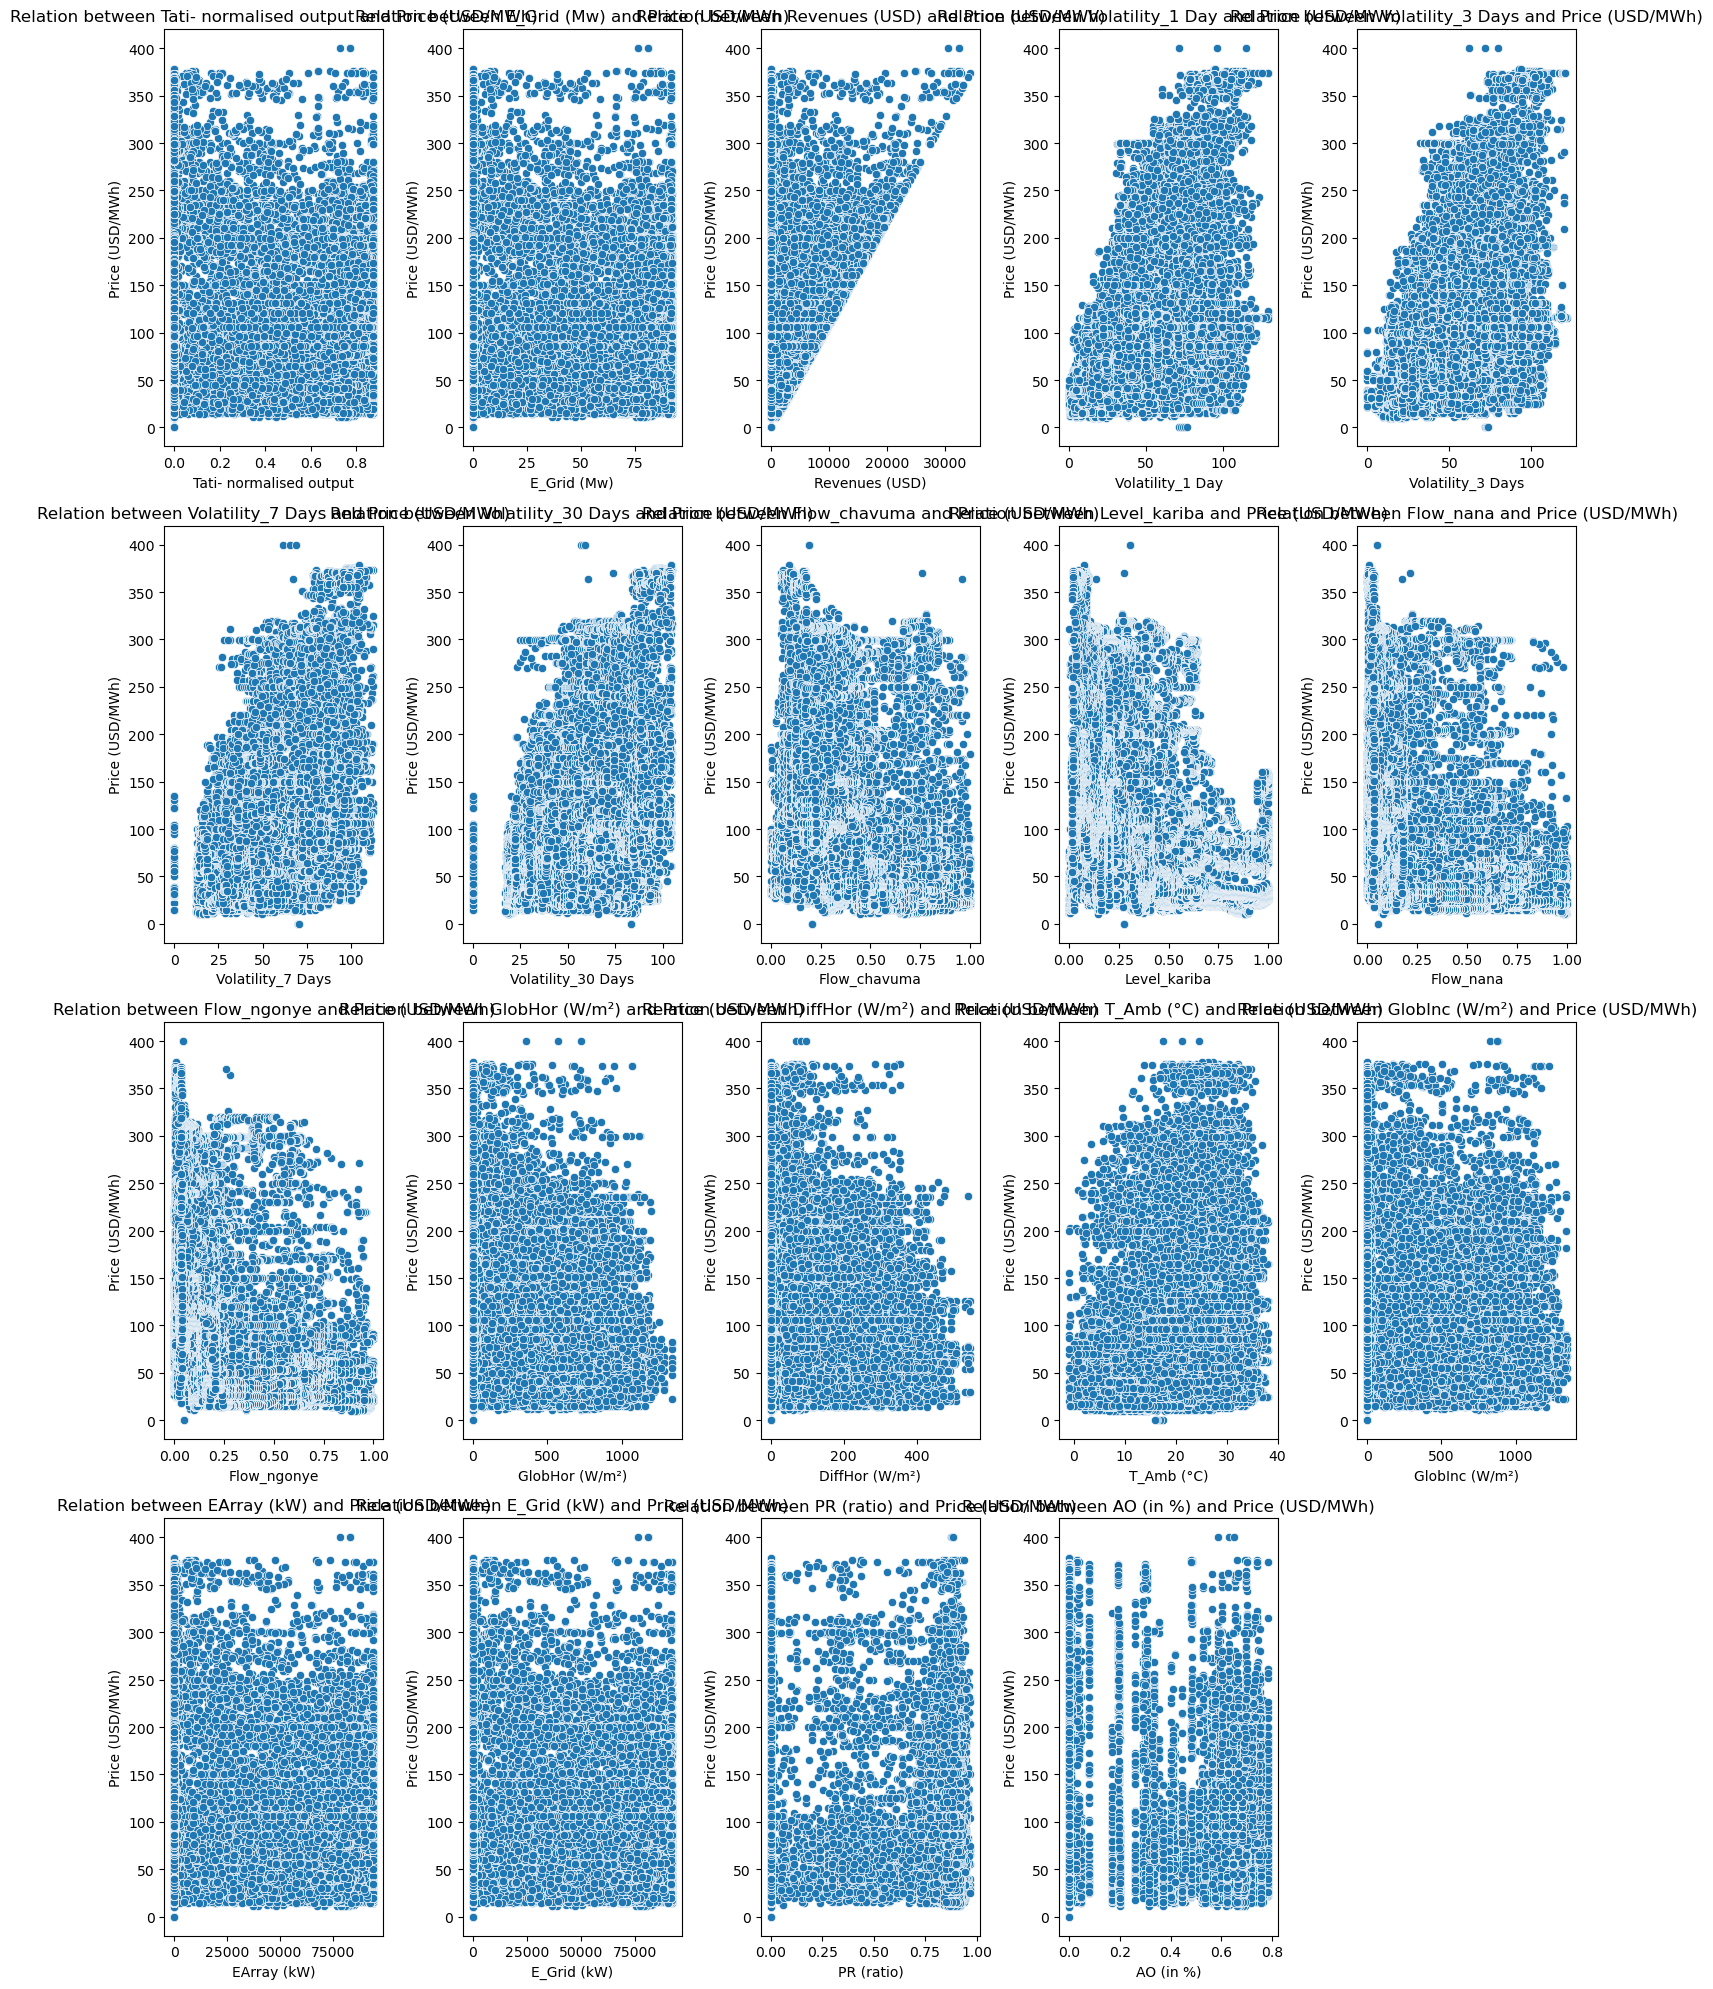

In [61]:
import math
# List of relevant variables (excluding Date, Month, and Hour)
variables = [
    'Tati- normalised output', 'E_Grid (Mw)', 'Revenues (USD)', 
    'Volatility_1 Day', 'Volatility_3 Days', 'Volatility_7 Days', 'Volatility_30 Days',
    'Flow_chavuma', 'Level_kariba', 'Flow_nana', 'Flow_ngonye',
    'GlobHor (W/m²)', 'DiffHor (W/m²)', 'T_Amb (°C)', 'GlobInc (W/m²)', 
    'EArray (kW)', 'E_Grid (kW)', 'PR (ratio)', 'AO (in %)'
]

# Calculate the number of rows and columns for the subplot grid
n_vars = len(variables)
n_cols = 5  # Number of columns in the grid (you can adjust this)
n_rows = math.ceil(n_vars / n_cols)  # Calculate rows based on the number of columns

# Set up the subplots (using a grid layout)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten axes array for easier iteration if n_rows > 1
axes = axes.flatten()

# Loop over the variables and create a scatter plot for each one
for i, var in enumerate(variables):
    sns.scatterplot(data=zra_sgp_dam, x=var, y='Price (USD/MWh)', ax=axes[i])
    axes[i].set_title(f'Relation between {var} and Price (USD/MWh)', fontsize=12)
    axes[i].set_xlabel(var, fontsize=10)
    axes[i].set_ylabel('Price (USD/MWh)', fontsize=10)

# Hide any extra axes if the grid has unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

This correlation heatmap provides a comprehensive view of the linear relationships between various features and the target variable, electricity price (USD/MWh). The most significant positive correlations with price are found in volatility-related features, especially Volatility_1_Day (0.49), Volatility_3_Days (0.45), and Volatility_7_Days (0.45), indicating that higher short-term market volatility tends to be associated with elevated electricity prices. Interestingly, Revenues (USD) also shows a moderate positive correlation (0.32), though this may reflect price as a component of revenue rather than being an independent predictor.

On the other hand, several hydro-related features such as Flow_chavuma, Flow_kariba, and Flow_ngonye show weak negative correlations (around -0.22 to -0.23), suggesting a possible inverse relationship between water flow and market price—perhaps due to increased supply leading to lower prices. Solar irradiance (GlobHor, GlobInc) and solar energy production metrics (EArray, E_Grid) appear to have very low or near-zero correlation with price, indicating that these features alone may not linearly influence pricing, or their effect may be captured indirectly through other dynamics.

Notably, many features—especially those related to solar and operational performance—show strong multicollinearity among themselves (with correlation values above 0.9), which is important to consider when designing models to avoid redundancy or instability. Overall, this heatmap reinforces the importance of volatility features in forecasting electricity prices and highlights the need for careful feature engineering and selection when using models like LSTMs.

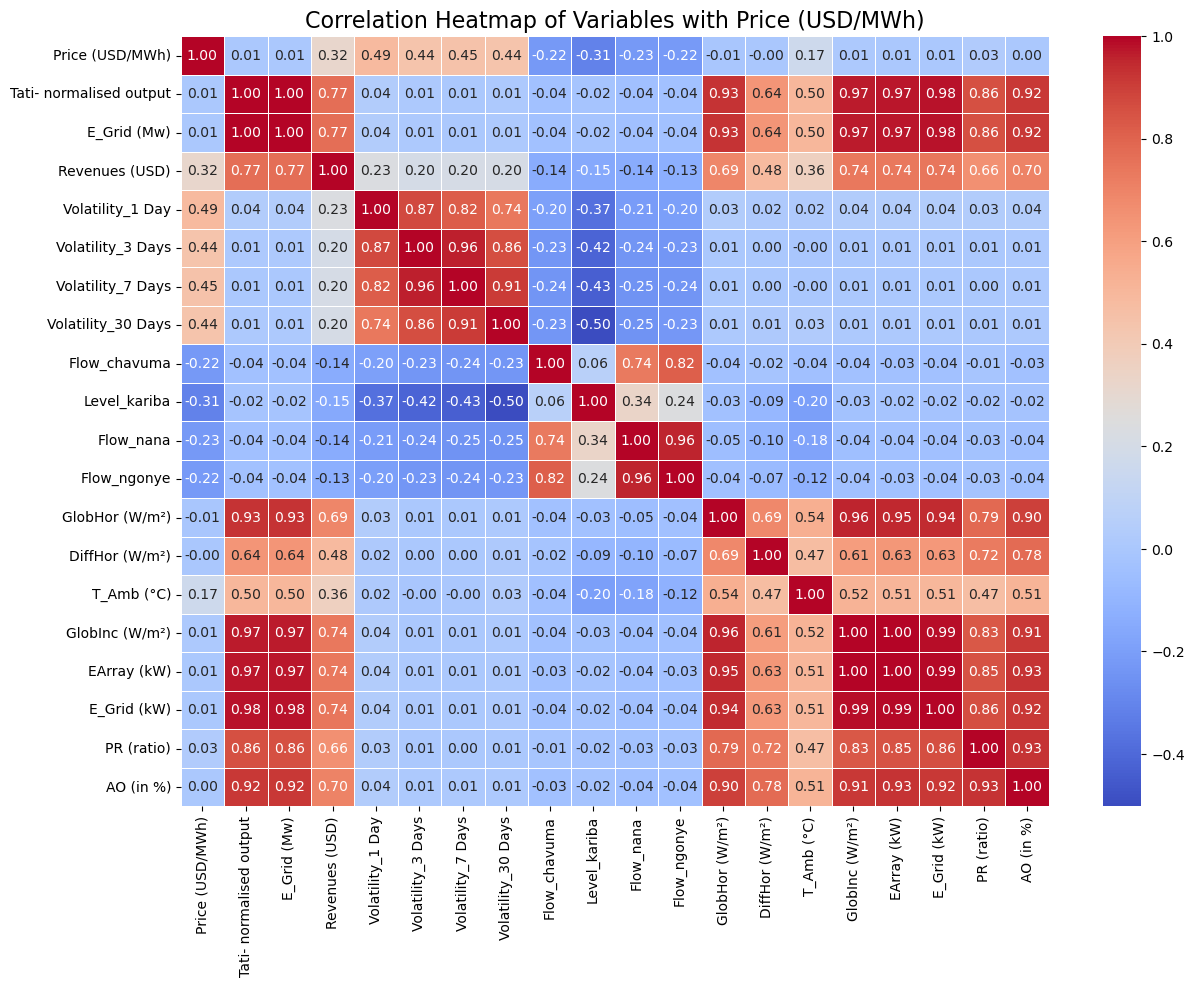

In [62]:
# Compute the correlation matrix for relevant columns (including the target 'Price (USD/MWh)')
correlation_matrix = zra_sgp_dam[['Price (USD/MWh)', 'Tati- normalised output', 'E_Grid (Mw)', 'Revenues (USD)', 
                                  'Volatility_1 Day', 'Volatility_3 Days', 'Volatility_7 Days', 'Volatility_30 Days',
                                  'Flow_chavuma', 'Level_kariba', 'Flow_nana', 'Flow_ngonye',
                                  'GlobHor (W/m²)', 'DiffHor (W/m²)', 'T_Amb (°C)', 'GlobInc (W/m²)', 
                                  'EArray (kW)', 'E_Grid (kW)', 'PR (ratio)', 'AO (in %)']].corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Title and display the heatmap
plt.title('Correlation Heatmap of Variables with Price (USD/MWh)', fontsize=16)
plt.show()

## Feature Importance Analysis
The feature importance analysis shown in the bar chart represents the results of a Random Forest regressor trained to predict electricity price (USD/MWh). The model achieved a Mean Squared Error (MSE) of 390, indicating the level of prediction error.

From the analysis, the most influential features for predicting price are:

- Hour – This is the most significant feature, suggesting that electricity prices vary substantially depending on the time of day.

- Volatility (1 Day) – Short-term volatility in electricity prices plays a critical role, likely due to market fluctuations.

- Revenues (USD) – Revenue is also a key factor, possibly linked to supply and demand dynamics.

- Level Kariba – The water level at Kariba Dam is an important predictor, likely because it affects hydroelectric generation.

- E_Grid (MW) – The grid electricity output also impacts price predictions.

Lesser influential features include various weather conditions (e.g., temperature, solar radiation), flow measurements from different rivers, and production-related metrics. Their lower importance suggests that while they may have some impact, they contribute less directly to price fluctuations.

Given the MSE of 390, there may be room for improvement in the model, possibly by fine-tuning hyperparameters, incorporating additional external factors, or experimenting with different regression techniques.
Note: this was before the small variables were included. These have now impacted the results.

In [63]:
zra_sgp_dam.columns

Index(['Date', 'Price (USD/MWh)', 'Tati- normalised output', 'E_Grid (Mw)',
       'Revenues (USD)', 'Volatility_1 Day', 'Volatility_3 Days',
       'Volatility_7 Days', 'Volatility_30 Days', 'Flow_chavuma',
       'Level_kariba', 'Flow_nana', 'Flow_ngonye', 'GlobHor (W/m²)',
       'DiffHor (W/m²)', 'T_Amb (°C)', 'GlobInc (W/m²)', 'EArray (kW)',
       'E_Grid (kW)', 'PR (ratio)', 'AO (in %)', 'Month', 'Hour',
       'day_of_week', 'is_weekend', 'price_lag1d', 'price_lag7d',
       'price_lag14d', 'ema_22h', 'ema_168h', 'roc_49h', 'momentum_49h'],
      dtype='object')

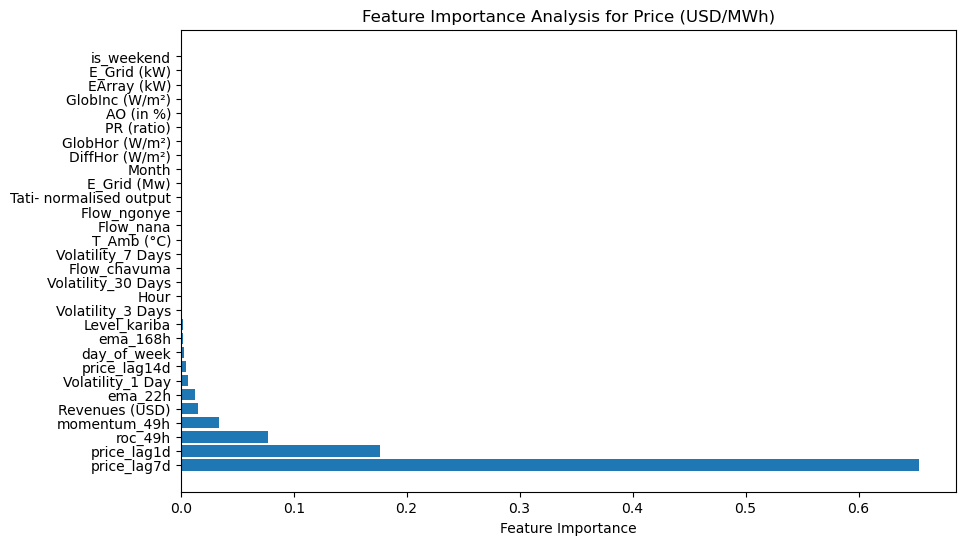

Mean Squared Error: 87.55118720540635


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming df_DAM is your DataFrame containing the features and target
# Define your features and target
features = ['Tati- normalised output', 'E_Grid (Mw)', 'Revenues (USD)', 'Volatility_1 Day', 
            'Volatility_3 Days', 'Volatility_7 Days', 'Volatility_30 Days', 'Flow_chavuma', 
            'Level_kariba', 'Flow_nana', 'Flow_ngonye', 'GlobHor (W/m²)', 'DiffHor (W/m²)', 
            'T_Amb (°C)', 'GlobInc (W/m²)', 'EArray (kW)', 'E_Grid (kW)', 'PR (ratio)', 
            'AO (in %)', 'Month', 'Hour','day_of_week', 'is_weekend', 'price_lag1d', 'price_lag7d','price_lag14d', 'ema_22h',
       'ema_168h', 'roc_49h', 'momentum_49h']

target = 'Price (USD/MWh)'

# Remove non-numeric or date columns from features if necessary
X = zra_sgp_dam[features]
y = zra_sgp_dam[target]

# Handle missing values if needed (e.g., fill with mean or drop rows)
X = X.fillna(X.mean())
y = y.fillna(y.mean())

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature importance extraction
feature_importances = rf.feature_importances_

# Create a DataFrame to view feature importance
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance Analysis for Price (USD/MWh)')
plt.show()

# Optionally, check model performance
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
